In [1]:
import pandas as pd
from pandas import DataFrame as dframe
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice

from jax import random, vmap
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro import sample, plate, param, deterministic
from numpyro.optim import Adam, Minimize
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Trace_ELBO, init_to_value, Predictive

import utils
from utils import dotdict
from utils.data import data, scale
from utils.analysis import * # precis, cov2cor
from utils.stats import * # r::stats functions (rnorm, dnorm, ...)
from utils.plots import init_dag, scatter, shade
utils.init() # init plotting styles and hush warnings
np.random.seed(8964) # seed

# Chapter 4 Geocentric Models

Claudius Ptolemy built some extremely accurate model for planet motions. The model is basically circles on circles on circles. With enough circles, he could accurately predict the location of a celestial body in the sky. But the model is simply wrong, although in some narrow domain of query it provides accurate answers. This modeling strategy is the same as a Fourier series. In this chapter, we are going to learn some geocentric models.

### Keywords
Prior predictive simulation, grid approximation, quadratic approximation, plausibility intervals, p-hacking, bayesian model interpretation, meaning of parameters, pair plots, prediction v. data plot (mean prediction, regression line samples), contour plots, regression line HDI plots, vectorizing maps, polynomial regression, B-splines.



---
## Section 4.1. Why normal distributions are normal

Consider the Galton's board as an example. McElreath gave a random walk example similar to that. Let's simulate that here. Say 1000 people were to do random walks from the left end of the yard to the right end. And it takes 16 steps. At each left-to-right step, each person either goes up or down by a number between -1 and 1 also.

Learning outcomes:
- 4.1.1 - 4.1.3: when normality comes
- 4.1.4: justifications of using normal distributions

### Code 4.1 (random walks)

In [2]:
random_walks = np.hstack([np.zeros((1000, 1)), runif((1000, 16), -1, 1)]).cumsum(1)
df_random_walks = dframe(random_walks).T
df_random_walks.columns = "s" + df_random_walks.columns.astype(str)
df_random_walks["step"] = np.arange(17)
df_random_walks = df_random_walks.melt(id_vars=["step"], value_vars=df_random_walks.columns, value_name="position")

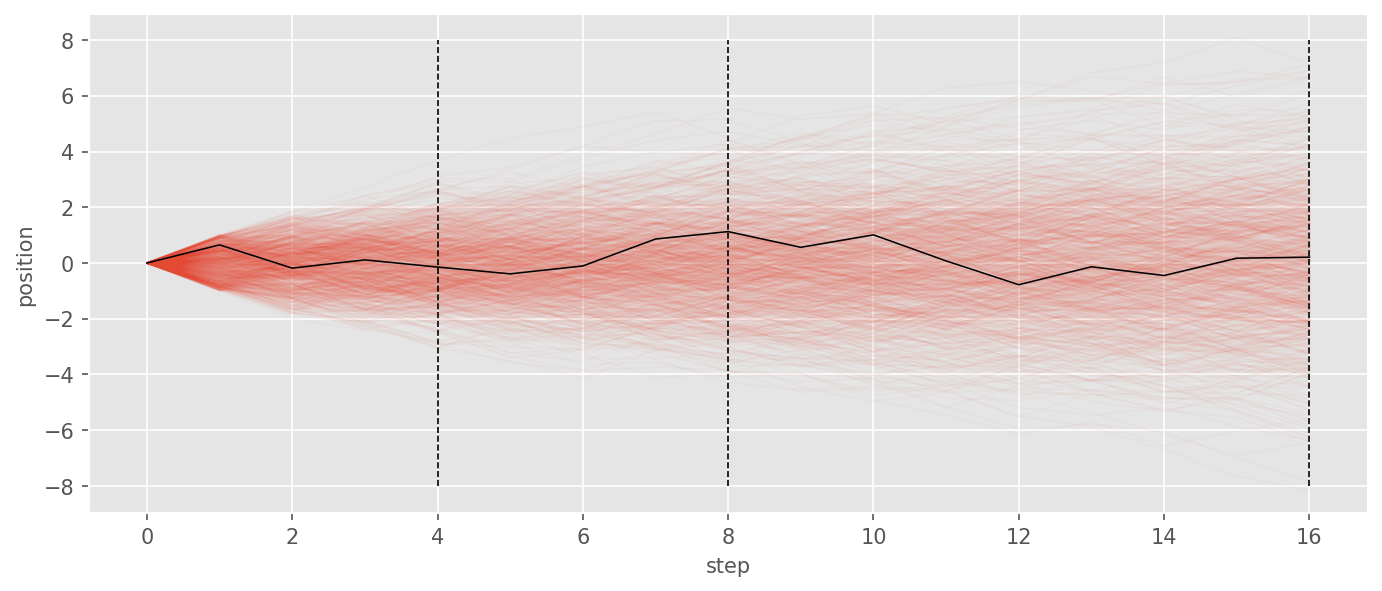

In [3]:
_, ax = plt.subplots()
sns.lineplot(data=df_random_walks, x="step", y="position", units="variable", estimator=None, alpha=0.03, ax=ax)
sns.lineplot(data=df_random_walks[df_random_walks.variable == "s0"], x="step", y="position", ax=ax, color="k", linewidth=0.75)
ax.vlines(x=[4, 8, 16], ymin=-8, ymax=8, color="k", linestyles="dashed", linewidth=0.8);

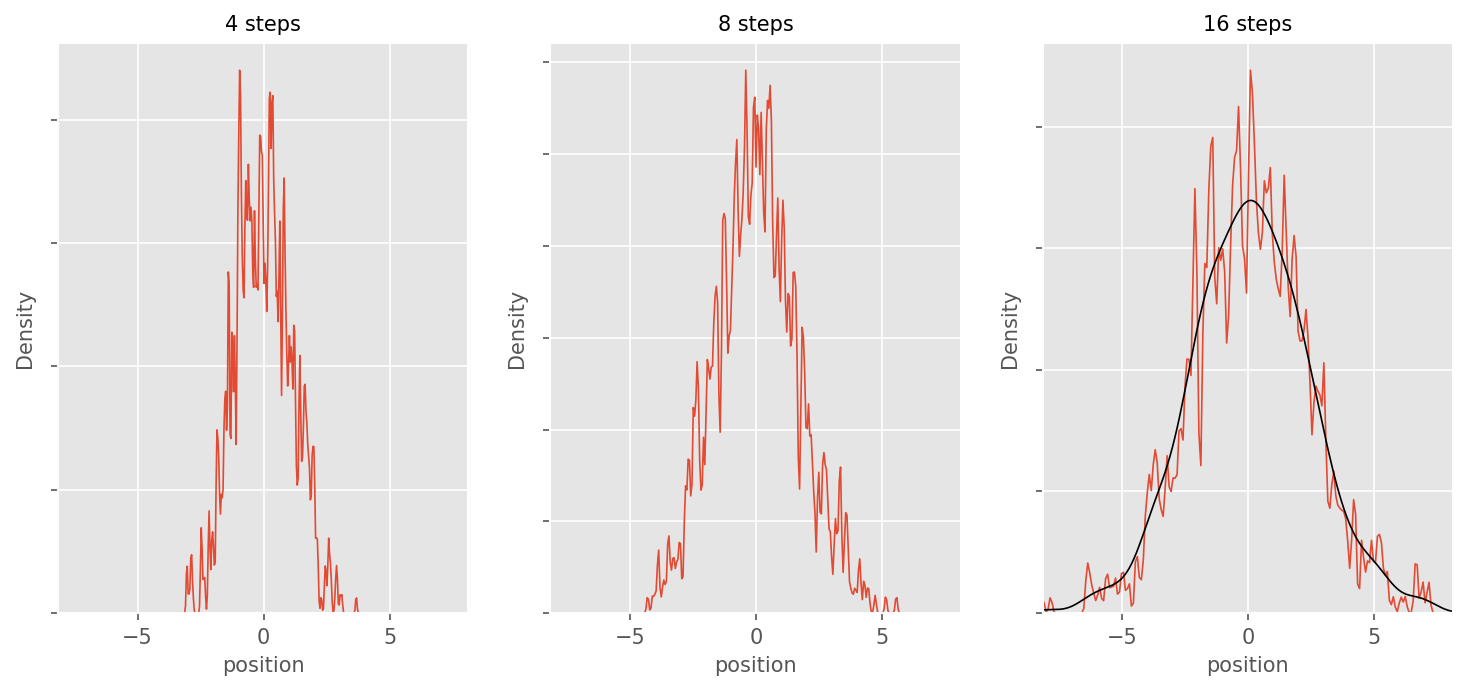

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.kdeplot(random_walks[:, 4], bw_adjust=.1, ax=ax[0])
sns.kdeplot(random_walks[:, 8], bw_adjust=.1, ax=ax[1])
sns.kdeplot(random_walks[:, 16], bw_adjust=.1, ax=ax[2])
sns.kdeplot(random_walks[:, 16], color="k", ax=ax[2])
ax[0].set(title="4 steps")
ax[1].set(title="8 steps")
ax[2].set(title="16 steps")
plt.setp(ax, xlabel="position", xlim=[random_walks.min(), random_walks.max()], yticklabels=[]);

If you add together independent random values from the same distribution, you always get a normal random variable. The underlying distribution of each value can be nearly anything, but the convergence will happen, sometimes slowly. 

### Code 4.2 (normality by multiplication)

Here's another to get a normal distribution.

In [5]:
runif(12, 1, 1.1).cumprod()

array([1.03932484, 1.09925859, 1.18139826, 1.25645023, 1.27039353,
       1.32847531, 1.39215171, 1.46857943, 1.47112896, 1.53952477,
       1.6067144 , 1.61512046])

### Code 4.3 (cont'd)

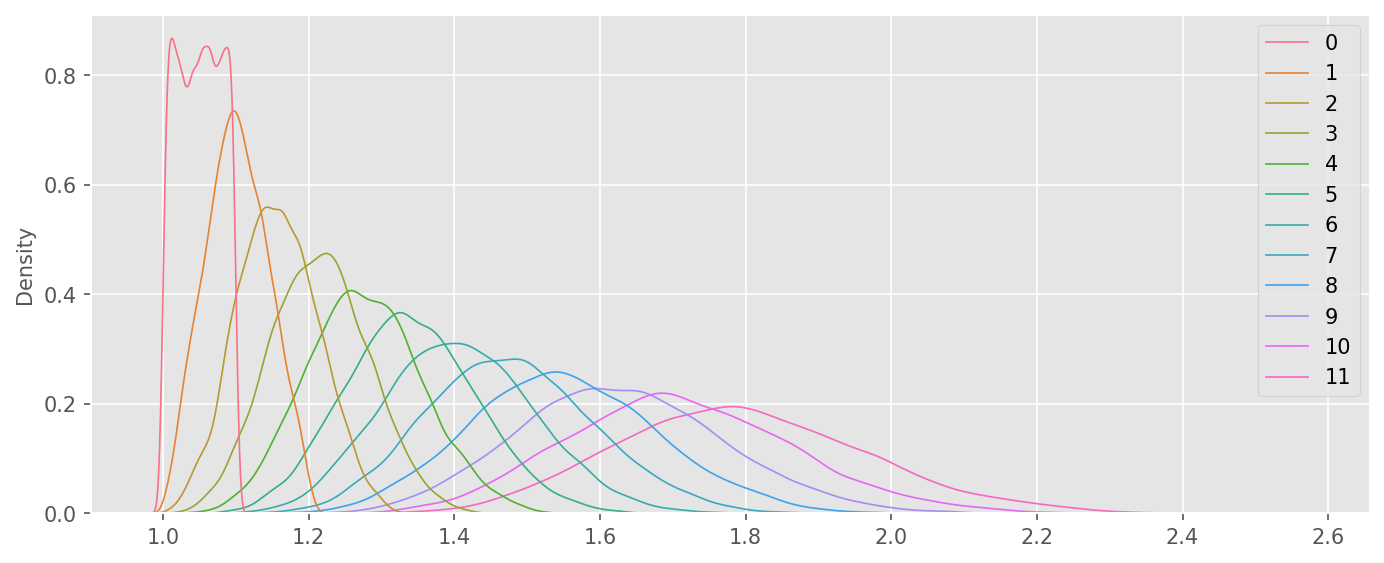

In [6]:
_, ax = plt.subplots()
growth = runif((int(1e4), 12), 1, 1.1).cumprod(1)
sns.kdeplot(growth, ax=ax);

### Code 4.4 (cont'd)

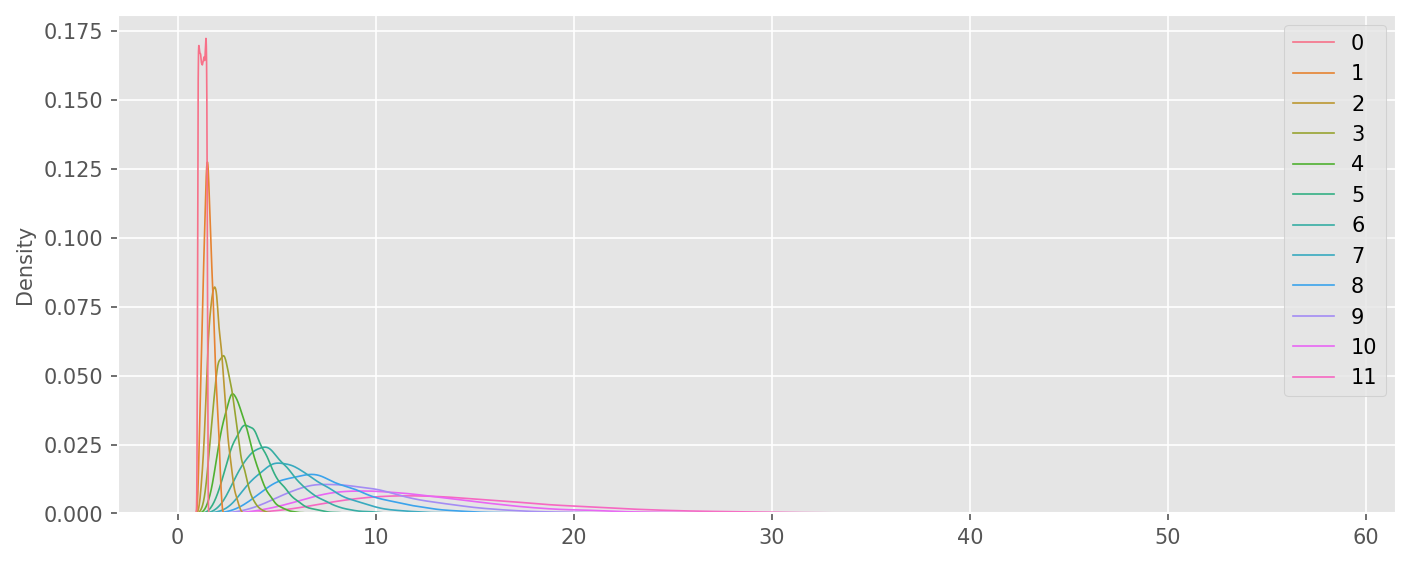

In [7]:
_, ax = plt.subplots()
growth = runif((int(1e4), 12), 1, 1.5).cumprod(1)
sns.kdeplot(growth, ax=ax);

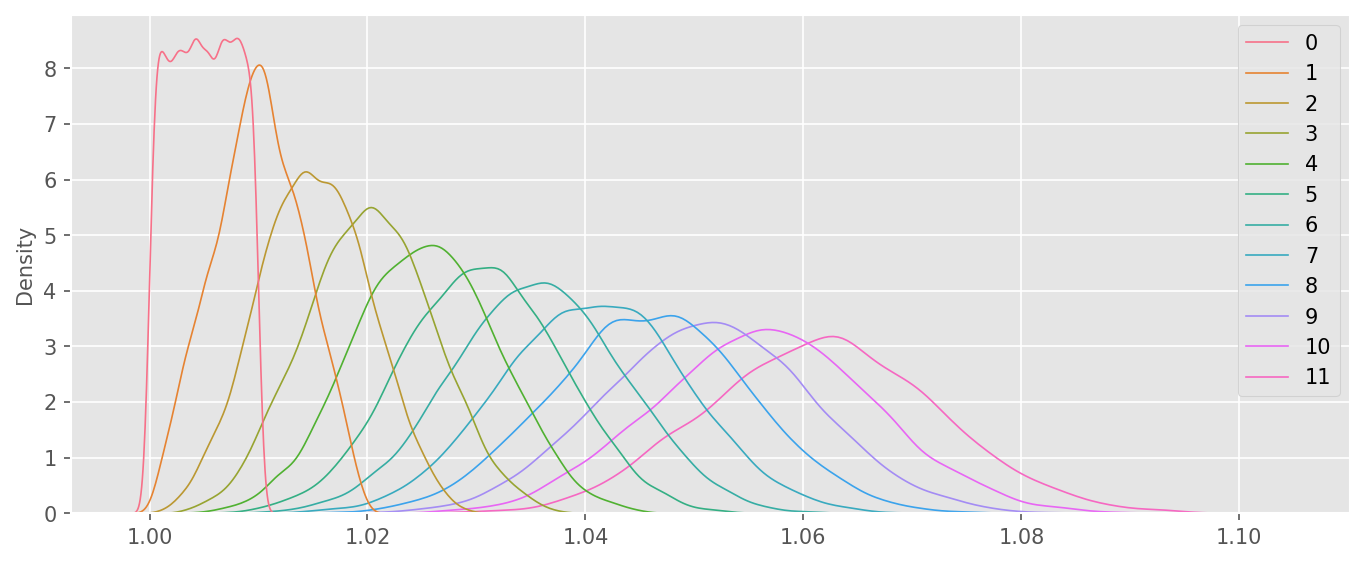

In [8]:
_, ax = plt.subplots()
growth = runif((int(1e4), 12), 1, 1.01).cumprod(1)
sns.kdeplot(growth, ax=ax);

The smaller the maximum multiplicative factor can be, the closer the curve is to the bell shape. But wait, large multiplicative factors do tend towards a log normal distribution.

### Code 4.5 (log normal growth)

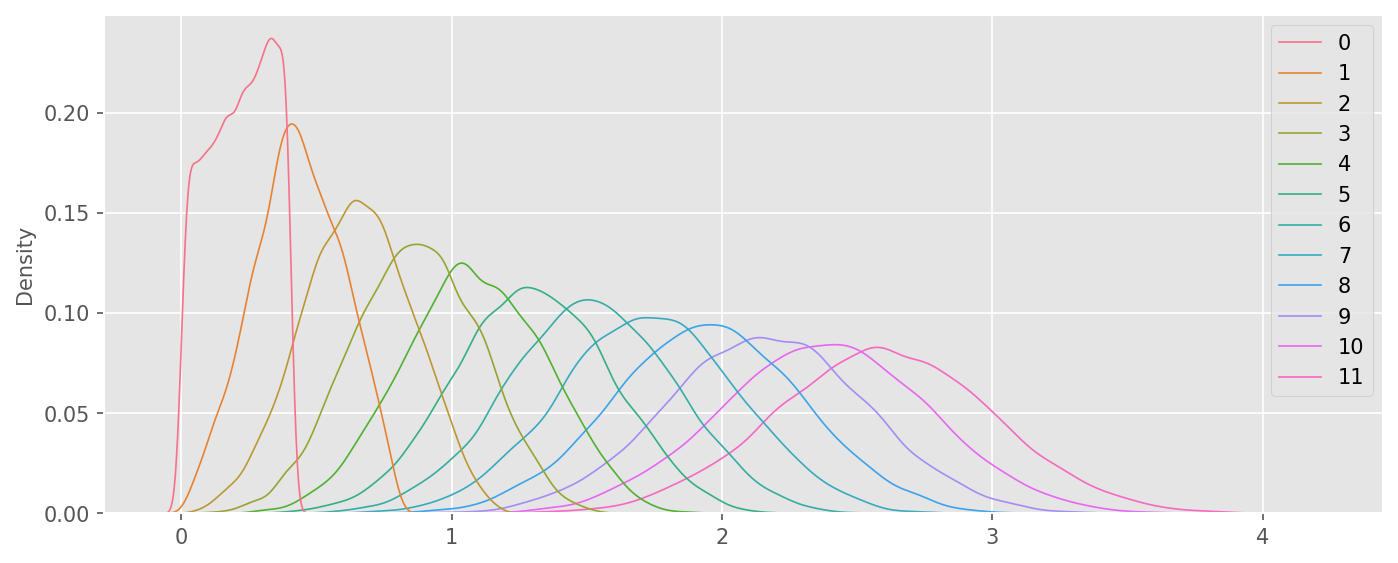

In [9]:
_, ax = plt.subplots()
log_big = np.log(runif((int(1e4), 12), 1, 1.5)).cumsum(1)
sns.kdeplot(log_big, ax=ax);

(4.1.4) The justifications for using normal distributions:
1. _Ontological justification_. Whenever there are processes that add together fluctuations, the fluctuations themselves might become less important than their mean and spread. Doing this often prevents us from knowing more about the underlying fluctuations. In a word, Gaussians are just part of the nature.
2. _Epistemological justification_. Gaussian distributions are the most natural expression of our state of ignorance, besides knowing the mean and the variance of the distribution. We will look into this more in later chapters when we talk about information theory and maximun entropy (maxent).

But many natural and unnatural processes have much heavier tails. For example, stock prices can look Gaussian in the short term, but extreme shocks during a long time window make the Gaussian model look foolish. 

An alternative parametrization of Gaussians uses $\tau = 1/\sigma^2$ instead of $\sigma$, called the "precision". 

---
## Section 4.2. A language for describing models

McElreath tends to refer to data as observed variables, and parameters as unobserved variables. So he makes that point here. Another point is that we should unify our language of defining our statistical models to a form that's similar to how stan or PyMC defines them with code. That way, you do not need to memorize the meaning of crazy terms like _heteroscedasticity_, you can just read the assumptions from your model definition.

### Code 4.6 (grid approximation)
Model:
$$W \sim \text{Binomial}(N, p)$$
$$p \sim \text{Uniform}(0, 1)$$

In [10]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = dbinom(w, n, p_grid)*dunif(p_grid, 0, 1)
posterior /= posterior.sum()

---
## Section 4.3. Gaussian model of height

We want our Bayesian model to rank all combinations of means and variances by the posterior plausibility.

### Code 4.7 (read Howell1 data)

In [11]:
from utils.data import data
d = data("Howell1")

### Code 4.8 (cont'd)

In [12]:
d

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
539  145.415  31.127751  17.0     1
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
542   71.120   8.051258   0.0     1
543  158.750  52.531624  68.0     1

[544 rows x 4 columns]

### Code 4.9 (cont'd)

In [13]:
precis(d)

mean     sd   5.5%   94.5%
height  138.26  27.60  81.11  165.74
weight   35.61  14.72   9.36   54.50
age      29.34  20.75   1.00   66.13
male      0.47   0.50   0.00    1.00

We are just studying the height column for now.

### Code 4.10 (cont'd)

In [14]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11 (cont'd)

Let's now just ignore the correlation between age and height that is often present in non-adults, by simplying filtering out the non-adults data points.

In [15]:
d2 = d[d.age >= 18]

Plot a density plot for the height and see if it looks like a bell curve. The answer is yes. This may be because height is a sum of many small growth factors. But gawking at the data to decide how to model them is usually not a good idea. 

**Rethinking: I.I.D.**. This assumption is hardly true in a physical sense. For the heights in the Howell data, it could be that some of these individuals are from the same families.

But the I.I.D. assumption doesn't need to seem awkward. It is an epistemological assumption, rather than an ontological one. It's only about how our models represent their uncertainty. Jaynes called this the [mind projection fallacy](https://en.wikipedia.org/wiki/Mind_projection_fallacy), when people confuse epistemological claims with ontological claims.

Let's build a model for the adult heights.
$$h_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(178, 20)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

Why 178 cm? McElreath is 178 cm tall. And 178 +- 40 encompasses a wide range of plausible human mean heights. Everybody knows something about human heights and thus can set a reasonable vague prior like this. But in many problems, using prior information is more subtle since parameters do not always have physical meaning. Whatever the prior, it's good to plot your priors for confirming what your assumptions are.

### Code 4.12 (plot prior of the mean heights)

See Figure 4.3 top left.

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
x = np.linspace(100, 250, 100)
ax[0, 0].plot(x, dnorm(x, 178, 20))
ax[0, 0].set(title="mu ~ dnorm(178, 20)", xlabel="mu")
plt.close()

### Code 4.13 (plot prior of the height variance)

See Figure 4.4 top right.

How should we pick the upper bound? A standard deviation of 50 cm would imply that 95% of individual heights lie within 100cm of the average height (small world numbers). That's a very large range.

In [17]:
x = np.linspace(-10, 60, 100)
ax[0, 1].plot(x, dunif(x, 0, 50))
ax[0, 1].set(title="sigma ~ dunif(0, 50)", xlabel="sigma");

### Code 4.14 (prior pred of first model)

It also helps to see what our priors imply about the simulated individual heights. (**prior predictive simulation**).

See Figure 4.3 bottom left.

In [18]:
n_samples = int(1e4)
sample_mu = rnorm(n_samples, 178, 20)
sample_sigma = runif(n_samples, 0, 50)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)

plt.setp(ax, yticklabels=[])
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 0])
ax[1, 0].set(title="h ~ dnorm(mu, sigma)", xlabel="height");

### Code 4.15 (prior pred, alt)

See Figure 4.3 bottom right.

Consider a much flatter prior $\mu \sim \text{Normal}(178, 100)$.  Note that there is a significant portion of humans with negative heights, also with heights more than 272 cm (one of the tallest people in history).

These crazy priors are not harmful here because we have 544 rows of data. But for cases where data are not sufficient, we have to use our scientific knowledge to construct sensible priors, then we can use Bayes to proceed.

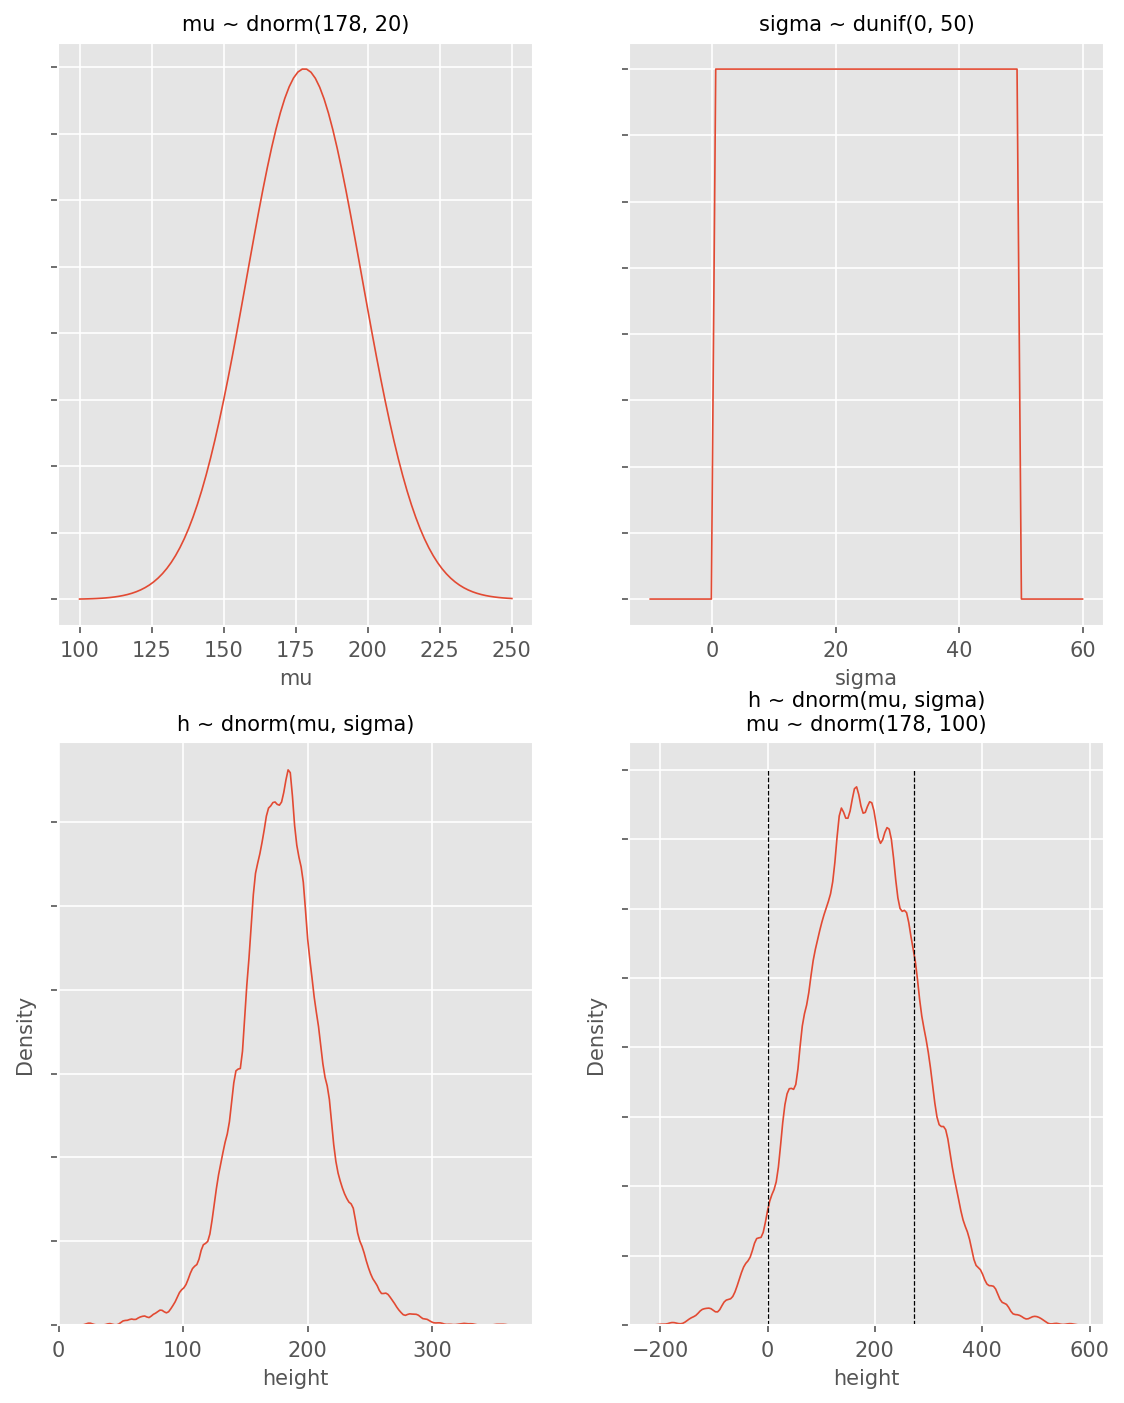

In [19]:
sample_mu = rnorm(n_samples, 178, 100)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 1])
ax[1, 1].vlines(x=[0, 272], ymin=0, ymax=0.004, linestyles=["dashed"], colors=["k"], linewidth=0.6)
ax[1, 1].set(title="h ~ dnorm(mu, sigma)\nmu ~ dnorm(178, 100)", xlabel="height")
fig

Figure 4.3. Top row: prior distributions for $\mu$ and $\sigma$. Bottom row: prior predictive simulations for height, left with the $\mu$ prior in our model, right with a flatter $\mu$ prior.

### Code 4.16 (grid approx, first model)

Since this is our first model, let's use grid approximation to calculate the posterior.


In [20]:
mus = np.linspace(150, 160, 100)
sigmas = np.linspace(7, 9, 100)
post_LL = dnorm(d2.height, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

### Code 4.17 (grid posterior contour)

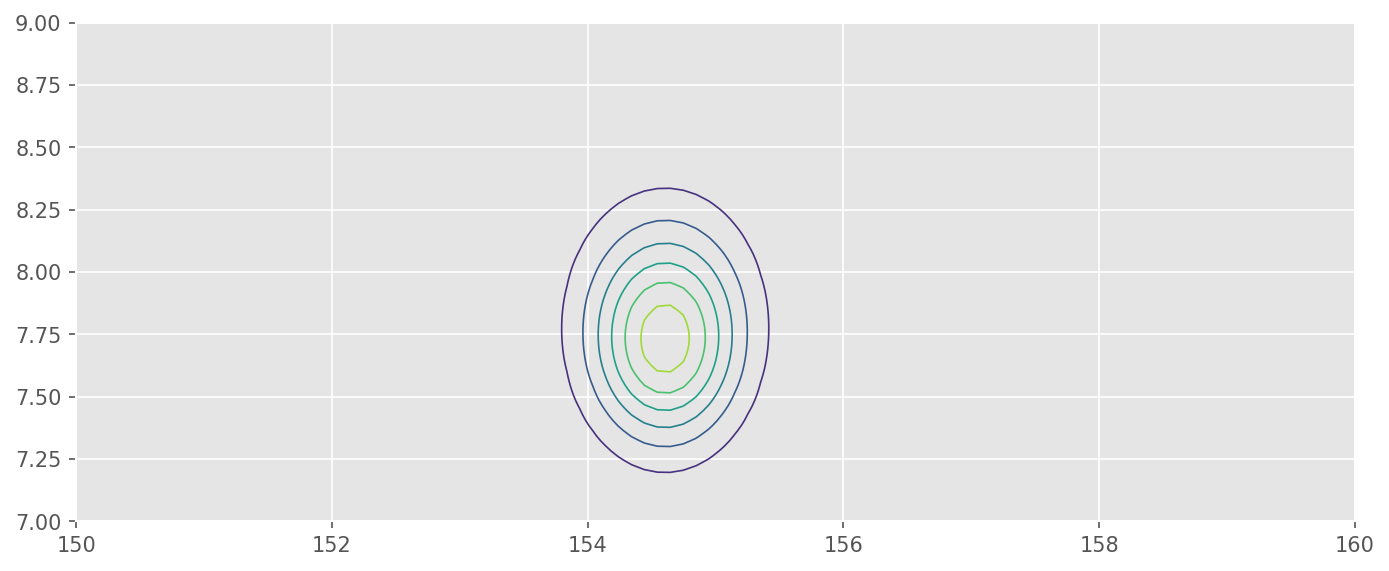

In [21]:
plt.contour(mus, sigmas, post_prob);

### Code 4.18 (2d grid posterior heatmap)

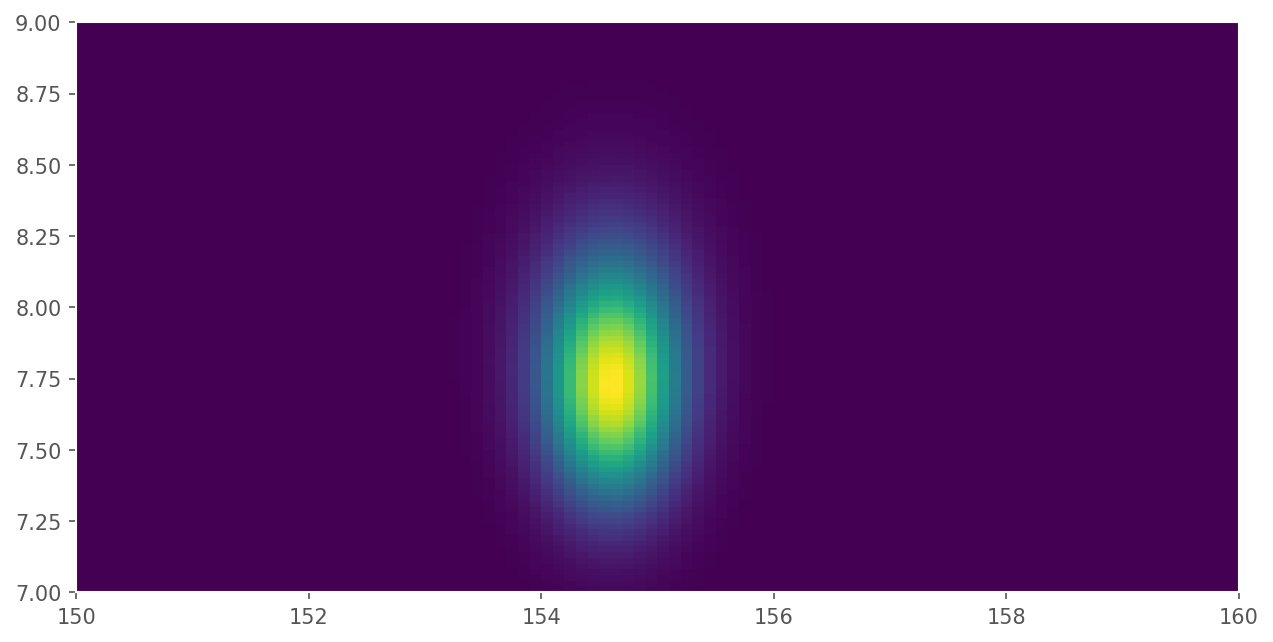

In [22]:
_, ax = plt.subplots(figsize=(10, 4))
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

### Code 4.19 (posterior sample from 2d grid)

In [23]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

### Code 4.20 (plot sampled 2d params)

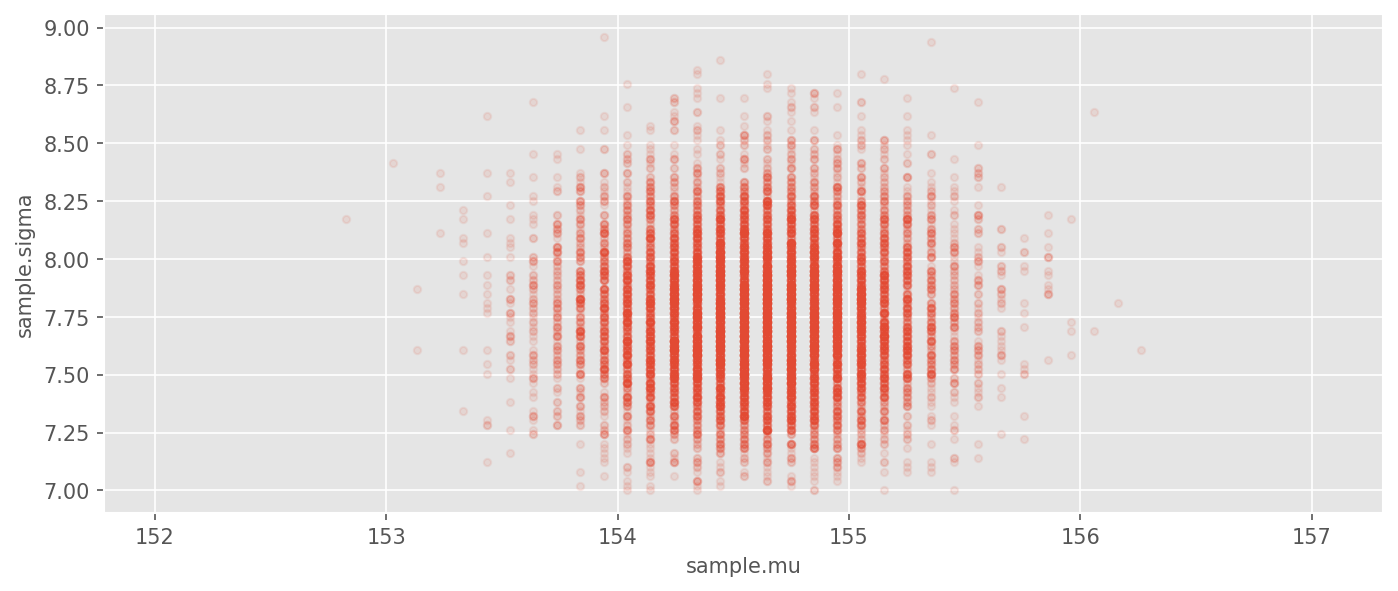

In [24]:
_, ax = plt.subplots()
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

Figure 4.4. Samples from the posterior distribution for the heights data.

### Code 4.21 (marginal plots)

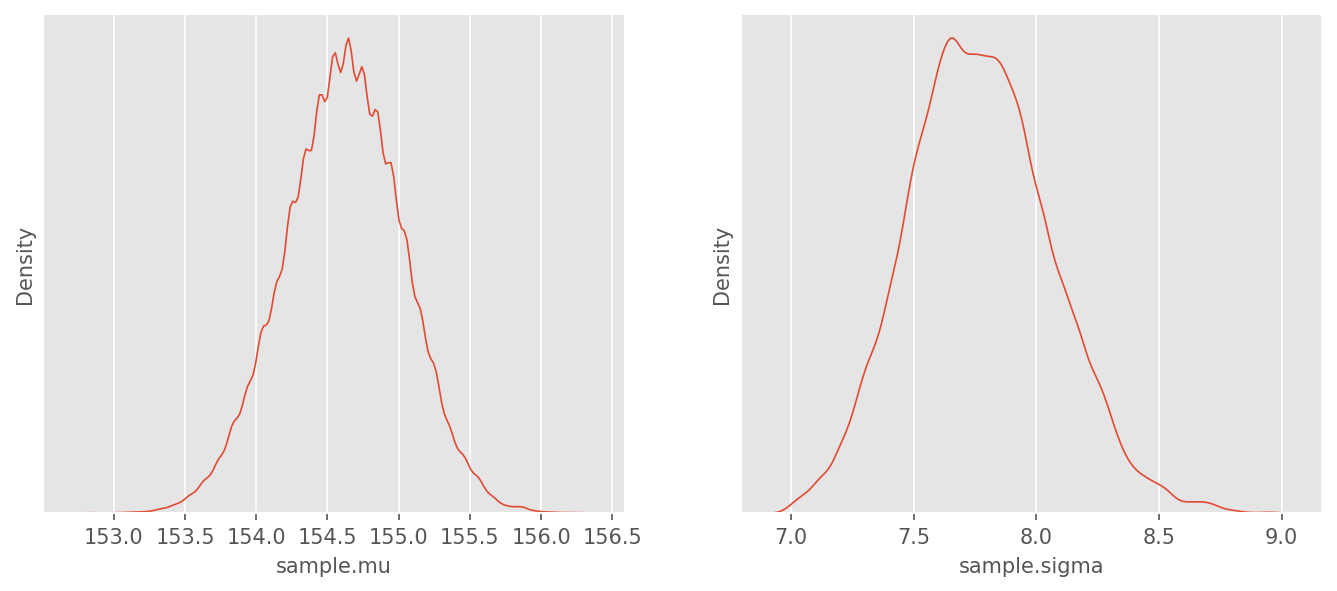

In [25]:
_, ax = plt.subplots(1, 2)
sns.kdeplot(sample_mus, bw_adjust=.7, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(sample_sigmas, bw_adjust=.7)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

### Code 4.22 (plausibility intervals)

In [26]:
hpdi(sample_mus, prob=.89), hpdi(sample_sigmas, prob=.89)

(array([153.83838384, 155.15151515]), array([7.26262626, 8.19191919]))

We are about to forget the grid approximation and get to quadratic approximation. Often if you do quadratic approximation for your normal posterior, the $\sigma$ tends to have a long right tail. An intuitive explanation is, the bigger the variance, the bigger the uncertainty.

It is deemed worth repeating the analysis of the height data above, but now with only a fraction of the data, to demonstrate the point discussed above.

### Code 4.23 (subset of Howell1)

In [27]:
d3 = choice(d2.height, 20)

### Code 4.24 (grid approx on subset)

In [28]:
mus = np.linspace(150, 170, 200)
sigmas = np.linspace(4, 20, 200)
post_LL = dnorm(d3, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

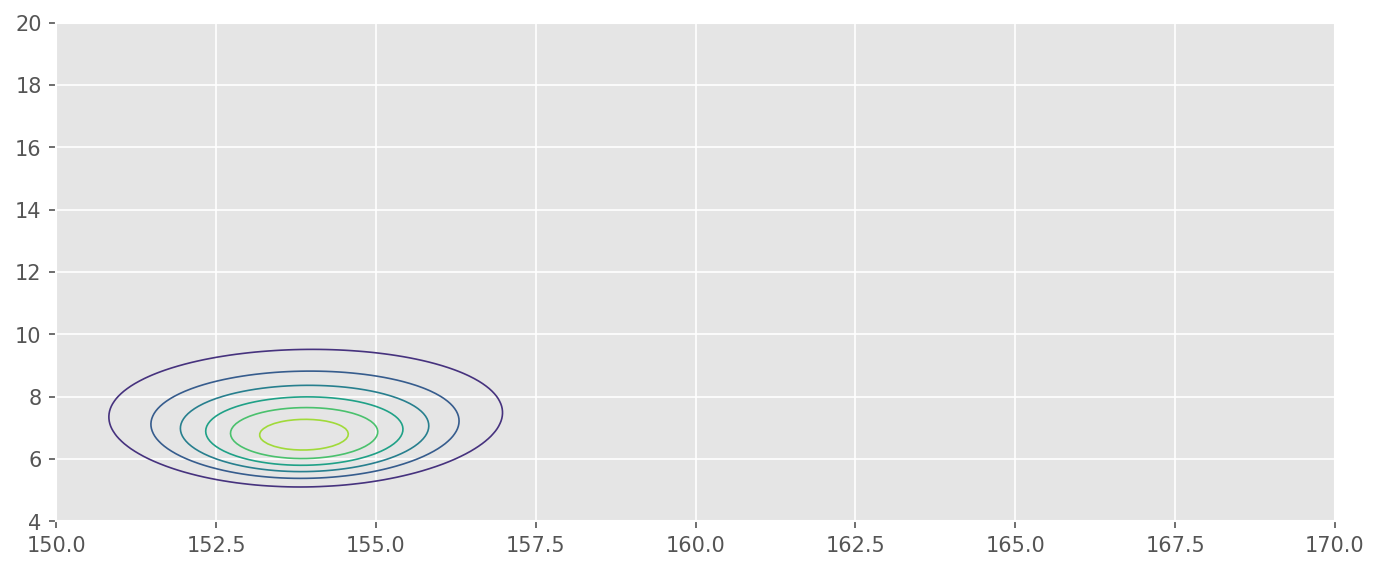

In [29]:
plt.contour(mus, sigmas, post_prob);

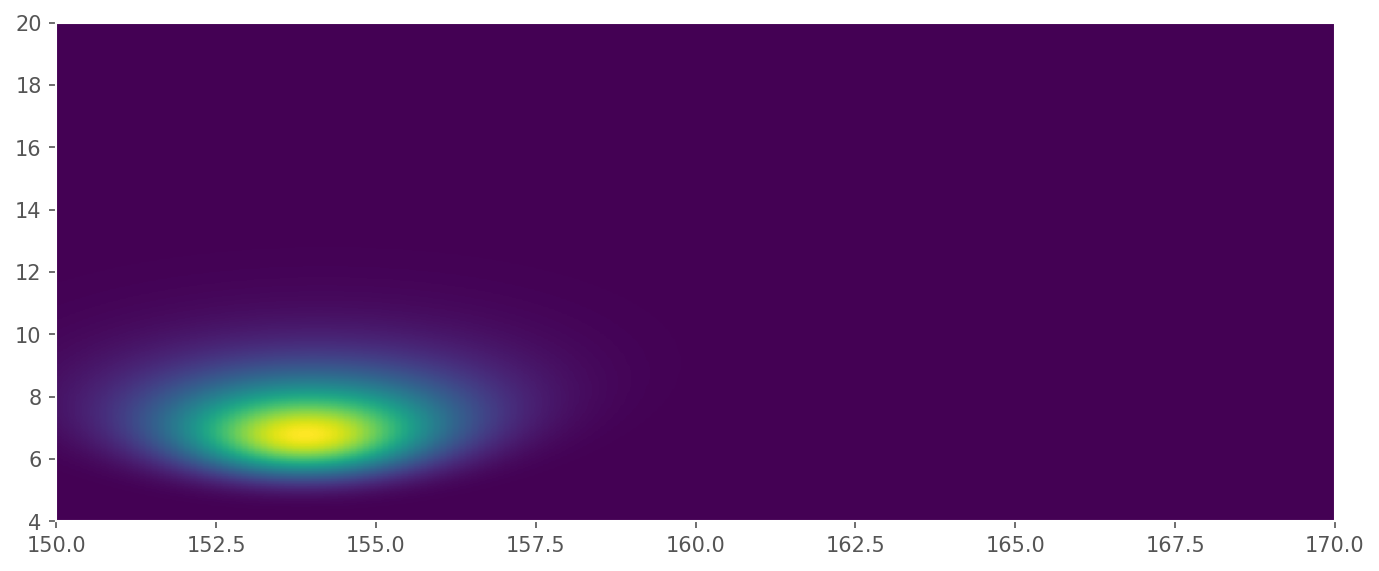

In [30]:
_, ax = plt.subplots()
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

In [31]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

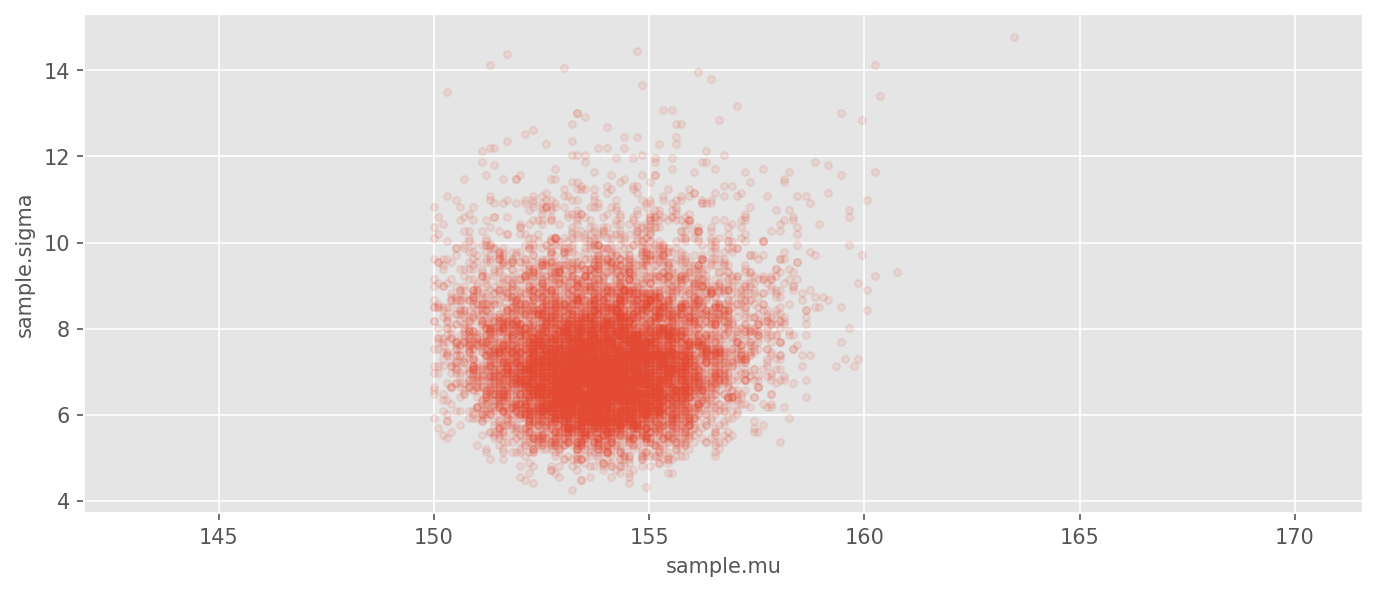

In [32]:
ax = plt.subplot(aspect="auto")
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

From the plots, we can see that sigma's posterior has a long right tail. Also see the posterior plot below.

### Code 4.25 (sigma posterior plot)

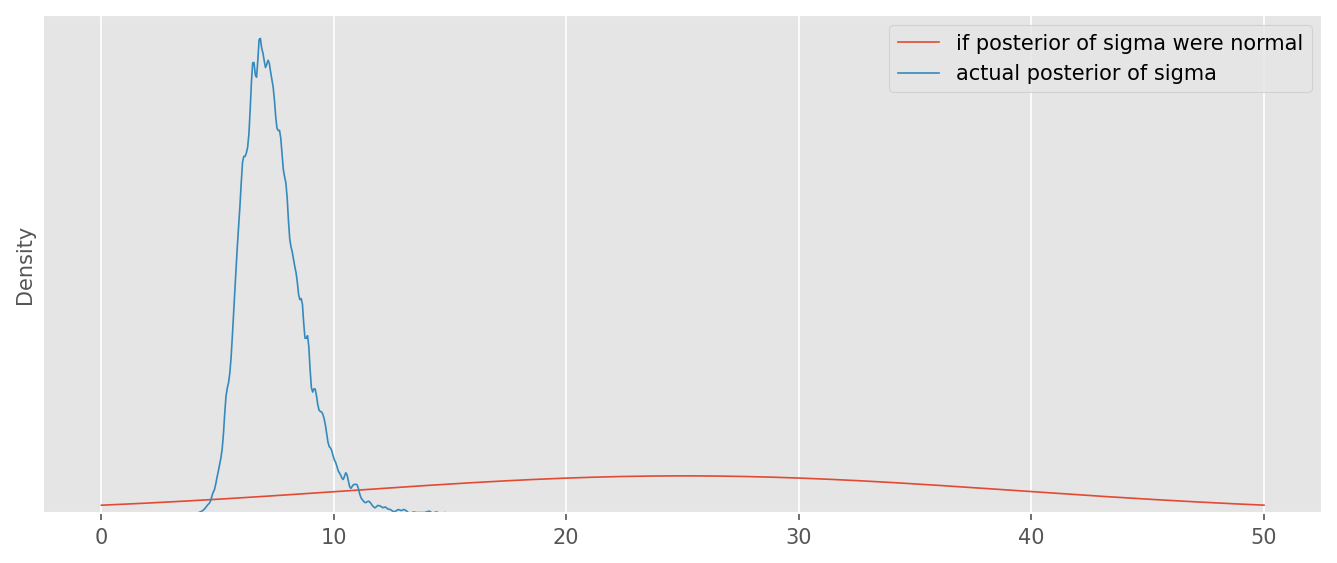

In [33]:
sigs = np.linspace(sample_sigma.min(), sample_sigma.max(), 200)
plt.plot(sigs, dnorm(sigs, sample_sigma.mean(), sample_sigma.std()), label="if posterior of sigma were normal")
sns.kdeplot(sample_sigmas, bw_adjust=.3, label="actual posterior of sigma")
plt.legend()
plt.yticks([]);

4.3.5 Quadratic approximation. This type of optimizer finds the peak/MAP/mode of the posterior, and also estimates the quadratic curvature at the MAP to produce an approximated posterior. **This is very similar to what many non-Bayesian procedures do, just without the priors.**

Consider a unimodal posterior density of $x$, $f(x)$, whose maximum is $x_0$. We can just approximate this density by doing a 2nd-order Taylor approximation around the posterior mode (given that we located the mode) on the log scale. The first order term becomes zero because the first derivative is evaluated at the mode, then we are left with a quadratic term to be then exponentiated (sounds quite familiar eh?), and a constant factor.

Laplace/normal/quadratic approximation replaces the problem of integration with the problem of maximization. Maximizing something often comes faster with a lot of off-the-shelf optimizers.

### Code 4.26 (reload Howell1 data)

In [34]:
d = data("Howell1")
d2 = d[d.age >= 18]

### Code 4.27 - 4.28 (quadratic approx with `numpyro` SVI) 

In [35]:
def f4_1(height=None):
    mu = sample("mu", dist.Normal(178, 20))
    sigma = sample("sigma", dist.Uniform(0, 50))
    sample("height", dist.Normal(mu, sigma), obs=height)

m4_1 = AutoLaplaceApproximation(f4_1)
svi = SVI(f4_1, m4_1, Adam(1), Trace_ELBO(), height=d2.height.values)
seed = random.PRNGKey(0)
m4_1_res = svi.run(seed, 2000)
p4_1 = m4_1_res.params
samples = m4_1.sample_posterior(seed, p4_1, (4000,))
precis(samples)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|█████████████████████| 2000/2000 [00:00<00:00, 3873.18it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]


mean    sd    5.5%   94.5%
mu     154.61  0.41  153.96  155.28
sigma    7.75  0.29    7.27    8.20

### Code 4.29 (sample posterior params)

In [36]:
dframe(samples).head()

mu     sigma
0  154.910355  7.465550
1  154.746201  7.779875
2  154.882416  7.375416
3  154.146408  7.574922
4  154.720688  7.828241

If comparing the above summary table with that from a grid approximation (summarize grid approximated samples from previous code this section), you will find they are quite similar. This is expected if the true posterior is approximately Gaussian.

**Overthinking: initial parameter values for finding the posterior mode.** In Code 4.27-4.28, the initial parameter values fed to the optimizer are sampled from the prior. But it's also possible to specify initial values with information from the data.

### Code 4.30 (quadratic approx, informed initial values)

In [37]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(f4_1, 
                                init_loc_fn=init_to_value(values=start))
vi4_1 = SVI(f4_1, m4_1, Minimize(), Trace_ELBO(), height=d2.height.values)
seed = random.PRNGKey(0)
res4_1 = vi4_1.run(seed, 2000)
p4_1 = res4_1.params
samples = m4_1.sample_posterior(seed, p4_1, (4000,))
precis(samples)

100%|██████████████████████| 2000/2000 [00:02<00:00, 743.65it/s, init loss: 1226.0387, avg. loss [1901-2000]: 1226.0389]


mean    sd    5.5%   94.5%
mu     154.61  0.41  153.97  155.27
sigma    7.66  0.29    7.19    8.09

### Code 4.31 (concentrated mu prior)

In [38]:
def f4_2(height=None):
    mu = sample("mu", dist.Normal(178, .1))
    sigma = sample("sigma", dist.Uniform(0, 50))
    sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = AutoLaplaceApproximation(f4_2)
svi = SVI(f4_2, m4_2, Adam(1), Trace_ELBO(), height=d2.height.values)
seed = random.PRNGKey(0)
m4_2_res = svi.run(seed, 2000)
p4_2 = m4_2_res.params
samples = m4_2.sample_posterior(seed, p4_2, (4000,))
precis(samples)

100%|██████████████████| 2000/2000 [00:00<00:00, 3695.39it/s, init loss: 1584193.6250, avg. loss [1901-2000]: 1626.5830]


mean    sd    5.5%   94.5%
mu     177.87  0.10  177.71  178.03
sigma   24.54  0.93   23.06   25.99

Notice that the posterior $\mu$ mode has hardly moved off the prior. But also notice that the $\sigma$ posterior mean has changed a lot from `m4_1`, even if we didn't modify the prior of $\sigma$. 

Once the golem is certain that `mu` is near 178 regardless of what the data says, then the golem needs to change where `sigma` lies to condition on that asserted belief, to get a good fit on the data. 

### Code 4.32 (get covariance matrix)

In [39]:
cov4_1 = m4_1.get_posterior(p4_1).covariance_matrix.round(3)
cov4_1

Array([[0.16600001, 0.        ],
       [0.        , 0.002     ]], dtype=float32)

### Code 4.33 (covar and corr matrices)

In [40]:
print(np.diag(cov4_1).round(3))
print(cov2cor(cov4_1).round(3))

[0.166 0.002]
[[1. 0.]
 [0. 1.]]


The near zero correlation between posterior $\mu$ and $\sigma$ means that learning one of the two does not tell anything about the second.

### Code 4.34 (sample posteriors)

In [41]:
post = m4_1.sample_posterior(seed, p4_1, (4000,))
post = dotdict(post)

### Code 4.35 (summarize sampled posteriors)

In [42]:
precis(post)

mean    sd    5.5%   94.5%
mu     154.61  0.41  153.97  155.27
sigma    7.66  0.29    7.19    8.09

Density plots of the posterior samples, generally similar to those from grid approximation (Code 4.21).

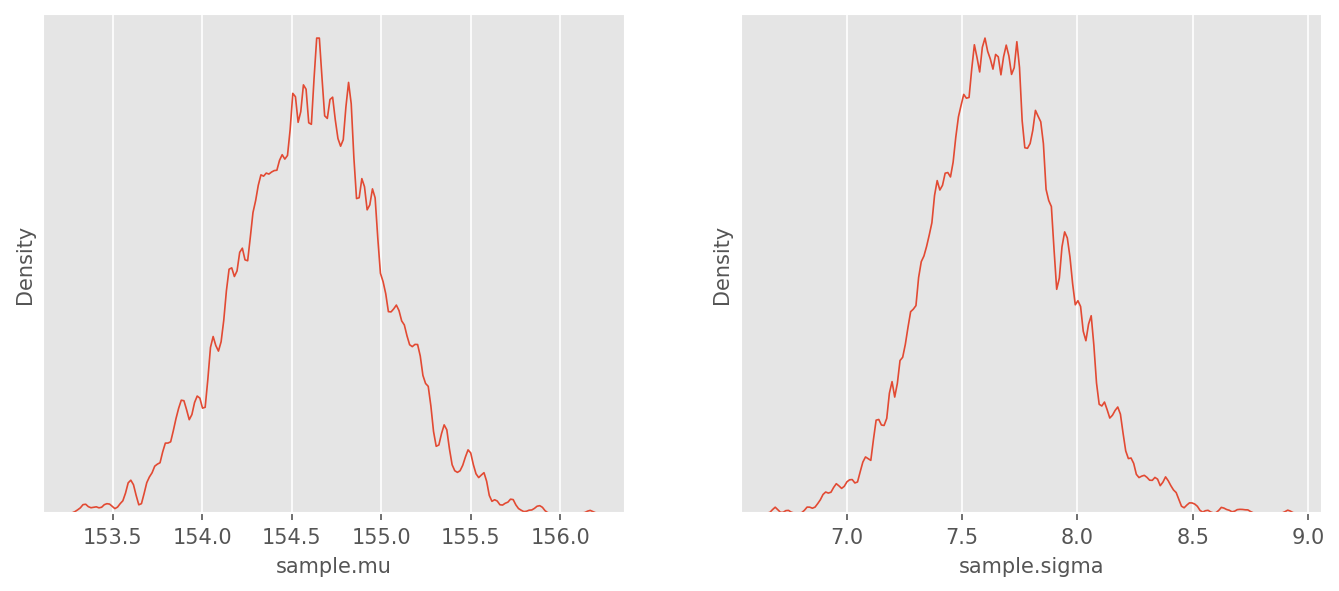

In [43]:
_, ax = plt.subplots(1, 2)
sns.kdeplot(post.mu, bw_adjust=.2, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(post.sigma, bw_adjust=.2)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

**Overthinking: Under the hood with multivariate sampling.** This is actually quite straightforward. I just called `scipy.stats.multivariate_normal.rvs` with learned parameters' MAPs and covariances. Check the source in `../utils/algos.py`.

### Code 4.36 (sampling mvnorm under the hood)

In [44]:
mean_dict = m4_1.median(p4_1)
means = []
for _, param_v in mean_dict.items():
    means.append(param_v.item())
    
from scipy.stats import multivariate_normal as mvnorm
post = mvnorm.rvs(size=int(1e4), mean=means, cov=cov4_1)

---
## Section 4.4 Linear prediction

Looking at the obvious association between two variables, height and weight, is dull. We'll try to add some thrill to the underlying theory of why those two are associated later. Right now, we focus on the mechanics of estimating two-variable association.

Now we ask the golem: "Consider all straight lines that relate one variable to the other. Rank all of these lines by plausibility given these data." The golem will answer with a posterior distribution.

### Code 4.37 (reg plot)



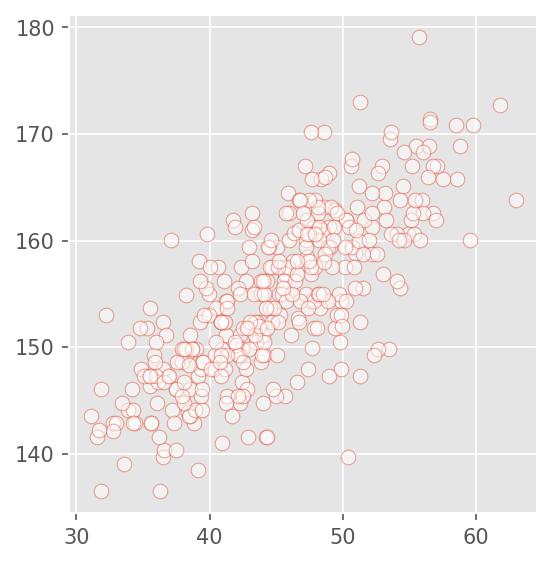

In [45]:
ax = plt.subplot(aspect=0.8)
scatter(d2.weight, d2.height, ax);

**Rethinking: Nothing special about linear models.**. You can include other functional forms in your regression formula, maybe using some underlying scientific theory. Models built out of substantive theory can dramatically outperform linear models of the same phenomena. We'll revisit this point later.

### Code 4.38 (simulate priors)

In [46]:
np.random.seed(2971)
N = 100
a = rnorm(N, 178, 20)
b = rnorm(N, 0, 10)

### Code 4.39 (plot priors)

See Figure 4.5.

In [47]:
fig, ax = plt.subplots(1, 2)

ax[0].set(title="b ~ dnorm(0, 10)", 
          xlim=[d2.weight.min(), d2.weight.max()])
ax[0].hlines(y=[0, 272], xmin=d2.weight.min(), xmax=d2.weight.max(), 
             color="k", linestyles="dashed")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 100)
for i in range(N):
    mu = a[i] + b[i]*(x - xbar)
    sns.lineplot(x=x, y=mu, alpha=0.2, color="k", ax=ax[0])
plt.close()

### Code 4.40 (`rlnorm` sampling)

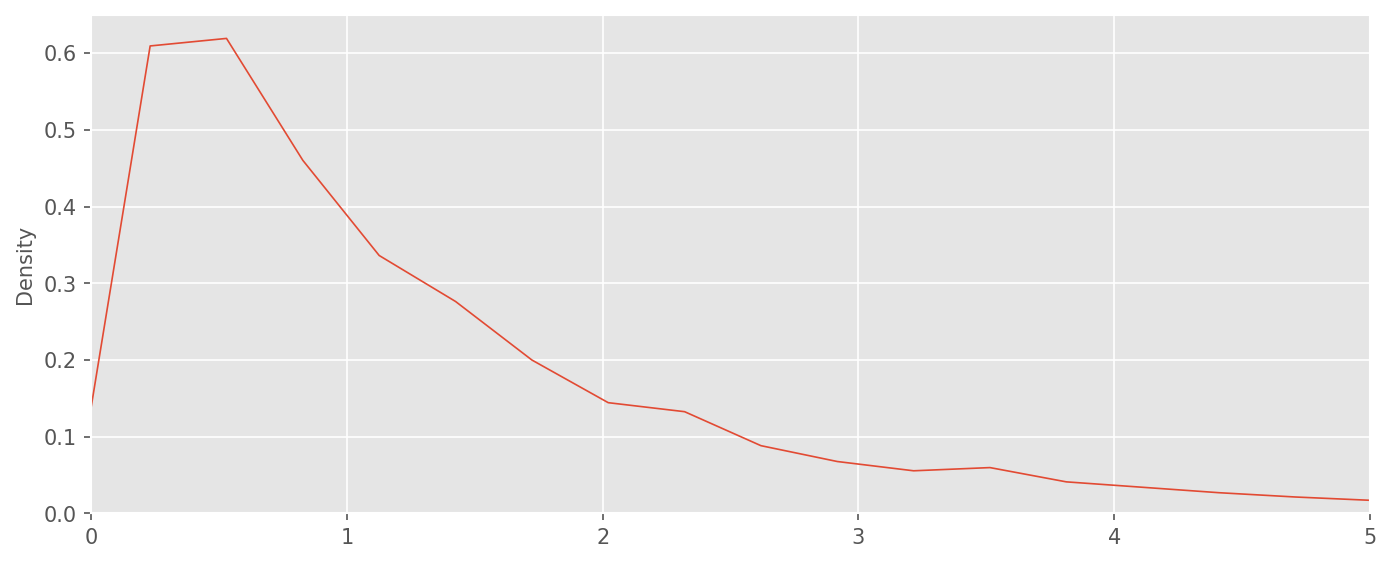

In [48]:
_, ax_ = plt.subplots()
b = rlnorm(int(1e4), 0, 1)
sns.kdeplot(b, bw_adjust=.1, ax=ax_)
ax_.set(xlim=[0, 5]);

### Code 4.41 (simulate priors, with lognormal slope)

In [49]:
np.random.seed(2971)
N = 100
a = rnorm(N, 178, 20)
b = rlnorm(N, 0, 1)

#### Exercise: plot priors with lognormal slope

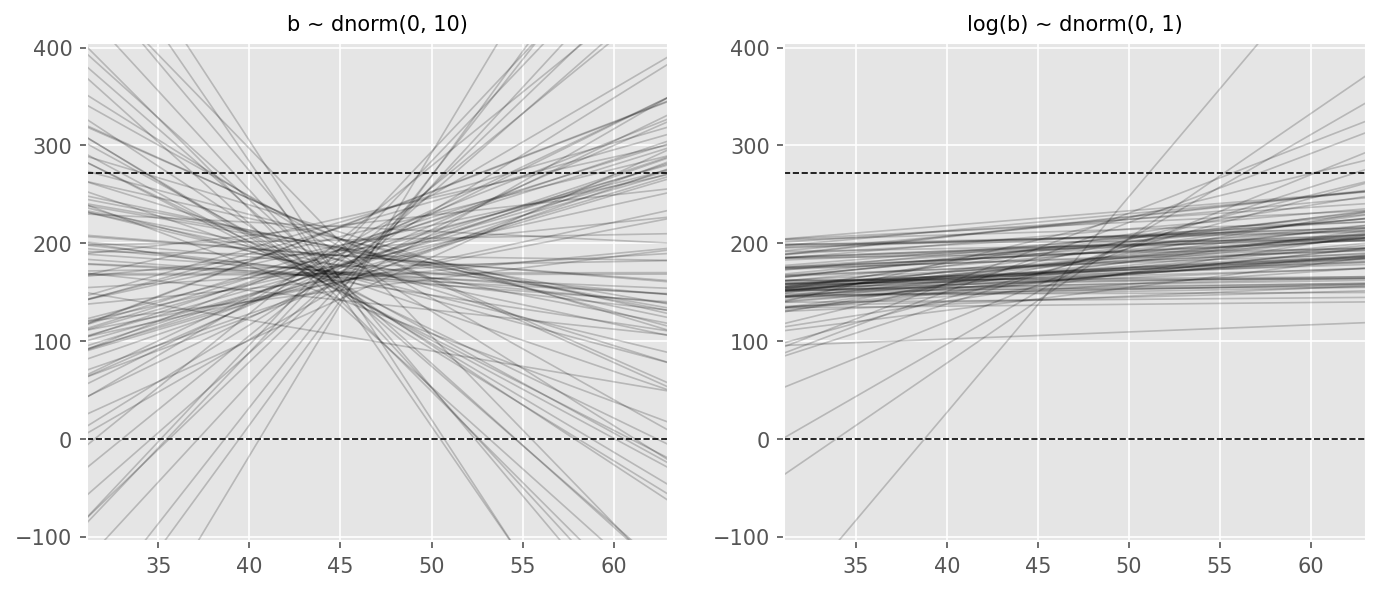

In [50]:
ax[1].set(title="log(b) ~ dnorm(0, 1)", 
          xlim=[d2.weight.min(), d2.weight.max()])
ax[1].hlines(y=[0, 272], xmin=d2.weight.min(), xmax=d2.weight.max(), 
             color="k", linestyles="dashed")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 100)
for i in range(N):
    mu = a[i] + b[i]*(x - xbar)
    sns.lineplot(x=x, y=mu, alpha=0.2, color="k", ax=ax[1])
plt.setp(ax, ylim=[-105, 405])
fig

Figure 4.5. Prior predictive simulation for the height and weight model. In fact, this dataset gives us enough data to make these priors not important at all after fitting the model. But thinking about priors can get us to better places if the amount of data is not sufficient, or if we want to go beyond geocentrism.

**Rethinking: What's the correct prior?**

Prior encodes states of information before seeing data. They allow us to explore the consequences of beginning with different information. If we confidently have some prior beliefs about the direction of variables' assocations, and/or the ranges the variables can take, we can strengthen our model priors with those beliefs.

**Rethinking: Prior predictive simulation and p-hacking.**

If we choose priors based on observed samples, that would be a form of p-hacking.

### Code 4.42 (`m4_3`, first height-weight model)

In [51]:
d = data("Howell1")
d2 = d[d.age >= 18]

def f4_3(w, h):
    a = sample("a", dist.Normal(178, 20))
    b = sample("b", dist.LogNormal(0, 1))
    sigma = sample("sigma", dist.Uniform(0, 50))
    wbar = w.mean()
    mu  = deterministic("mu", a + b*(w - wbar))
    height = sample("h", dist.Normal(mu, sigma), obs=h)
    
m4_3 = AutoLaplaceApproximation(f4_3)
vi4_3 = SVI(f4_3, m4_3, Minimize(), Trace_ELBO())
res4_3 = vi4_3.run(random.PRNGKey(0), 2000, w=d2.weight.values, h=d2.height.values)
p4_3 = res4_3.params

100%|██████████████████████| 2000/2000 [00:03<00:00, 661.86it/s, init loss: 1195.0201, avg. loss [1901-2000]: 1078.9297]


In [52]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

mean    sd    5.5%   94.5%
a      154.60  0.27  154.14  155.01
b        0.91  0.04    0.84    0.97
sigma    5.08  0.19    4.77    5.39

**Rethinking: Everything that depends upon parameters has a posterior distribution.** This includes variables being a deterministic function of parameters such as `mu` in `m4_3`, as well as model-based predictions and measures of fit. 

**Overthinking: Logs and exps, oh my.** Instead of `b` in `m4_3`, we can define the log of `b` and assign it to a normal distribution. Then we can exponentiate that thing for the linear model.

### Code 4.43 (`m4_3b`, log_b)

In [53]:
def f4_3b(w, h):
    a = sample("a", dist.Normal(178, 20))
    log_b = sample("log_b", dist.Normal(0, 1))
    sigma = sample("sigma", dist.Uniform(0, 50))
    wbar = w.mean()
    mu  = deterministic("mu", a + jnp.exp(log_b)*(w - wbar))
    height = sample("h", dist.Normal(mu, sigma), obs=h)
    
m4_3b = AutoLaplaceApproximation(f4_3b)
vi4_3b = SVI(f4_3b, m4_3b, Adam(1), Trace_ELBO())
res4_3b = vi4_3b.run(random.PRNGKey(0), 2000, w=d2.weight.values, h=d2.height.values)
p4_3b = res4_3b.params
post = m4_3b.sample_posterior(random.PRNGKey(1), p4_3b, (4, 1000))
precis(post, pars=["a", "log_b", "sigma"])

100%|████████████████████| 2000/2000 [00:00<00:00, 3446.90it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


mean    sd    5.5%   94.5%
a      154.60  0.27  154.14  155.01
log_b   -0.10  0.05   -0.17   -0.03
sigma    5.08  0.19    4.77    5.39

**4.4.3. Interpreting the posterior distribution.** 

There are 2 broad categories: (1) reading tables and (2) plotting simulations. This book emphasizes plotting instead of understanding a table. Plotting enables us to address the following:

<ol>
    <li>Whether the model fitting procedure worked correctly
    <li>The <i>absolute</i> magnitude, rather than merely the <i>relative</i> magnitude, of relationships between the outcome and the predictors.
    <li>The uncertainty surrounding an average relationship
    <li>The uncertainty surrounding model-based predictions
</ol>

**Rethinking: What do parameters mean?** There is no consensus. But in the Bayesian perspective, parameters are unknown states of the world. The posterior distribution of parameters describes _the relative compatibility of different states of the world with the data, according to the model_. These are small world numbers. People may disagree about the large world meaning. Such disagreements are productive, because they lead to model criticism and revision. Golems can't do that for themselves. 

In later chapters, we'll see that data can also be parameters. 

_4.4.3.1. Tables and pair plots of posterior._

### Code 4.44 (`m4_3` posterior summary)

Table interpretations.

In [54]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

mean    sd    5.5%   94.5%
a      154.60  0.27  154.14  155.01
b        0.91  0.04    0.84    0.97
sigma    5.08  0.19    4.77    5.39

Let's focus on `b`. `m4_3` thinks that _a person 1 kg heavier is expected to be 0.9 cm taller_. The 89% highest density interval of `b` means that any value outside of this interval is **not that compatible with these data and the `m4_3` model**.

It is most certainly not evidence that heights and weights have a linear relationship, since the model only consider lines. It just says that, if you are commited to a line, then lines with a slope around 0.9 are the most plausible ones.

Remember, numbers in `precis` are not sufficent to describe the quadratic posterior completely. For that we also need the covariance matrix. Also use `sns.PairGrid()` to show  

### Code 4.45 (`m4_3` post cov mat)

In [55]:
m4_3.get_posterior(p4_3).covariance_matrix.round(3)

Array([[0.07300001, 0.        , 0.        ],
       [0.        , 0.002     , 0.        ],
       [0.        , 0.        , 0.002     ]], dtype=float32)

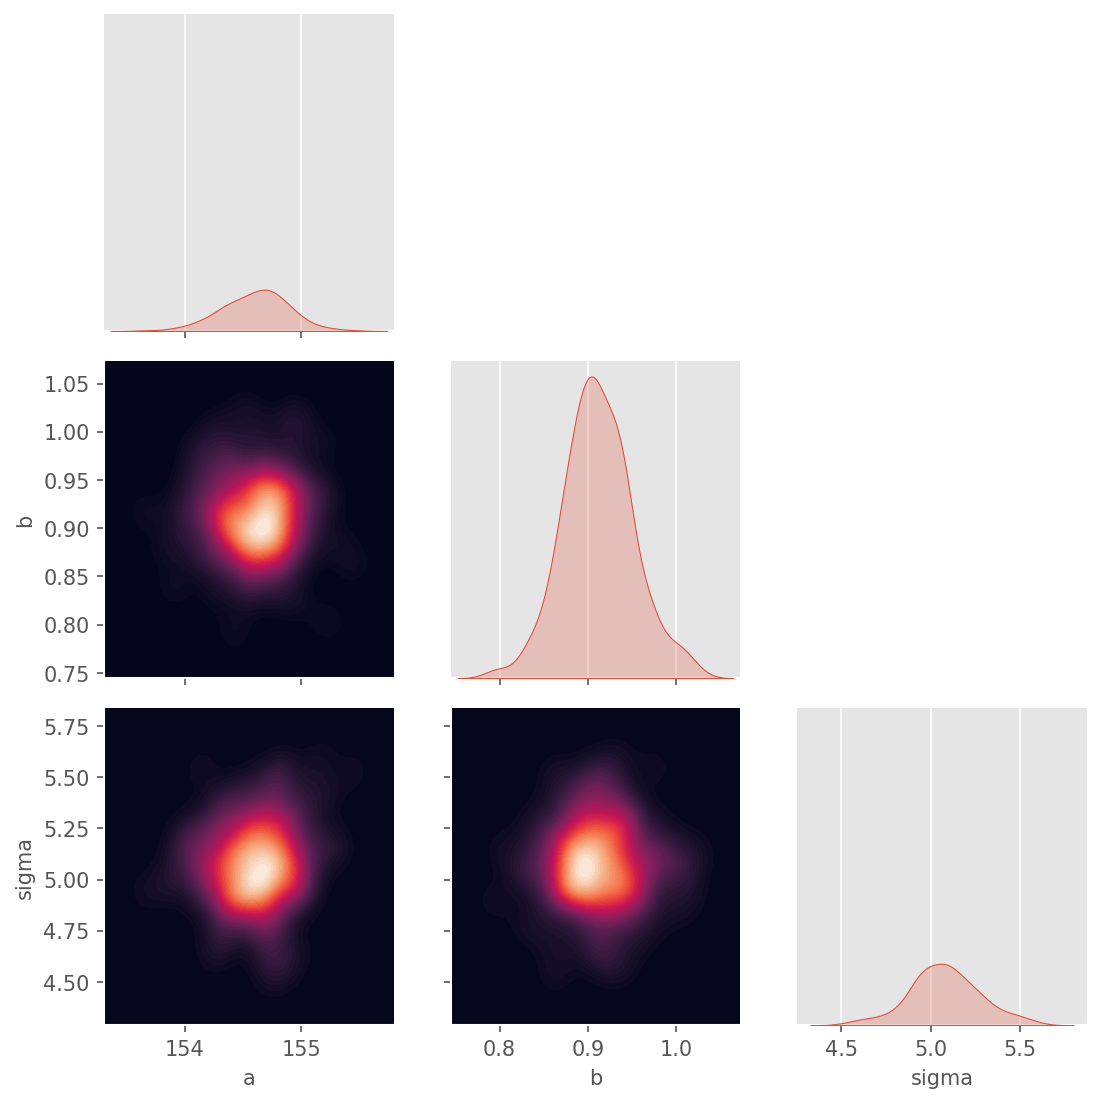

In [56]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (200,))
post.pop("mu")
g = sns.PairGrid(dframe(post), corner=True)
g.map_lower(sns.kdeplot, cmap="rocket", fill=True, thresh=0, levels=50)
g.map_diag(sns.kdeplot, fill=True);

_4.4.3.2. Plotting posterior inference against the data._

Next, we plot the model predictions against data. This helps to check whether the model is specified & fitted correctly, and interpret the posterior.

We start with plotting what mean heights should be for each weight value as per `m4_3` against data. Then we'll add more information into the plots, until we've used the entire posterior distribution.

### Code 4.46 (posterior mean height v. data)

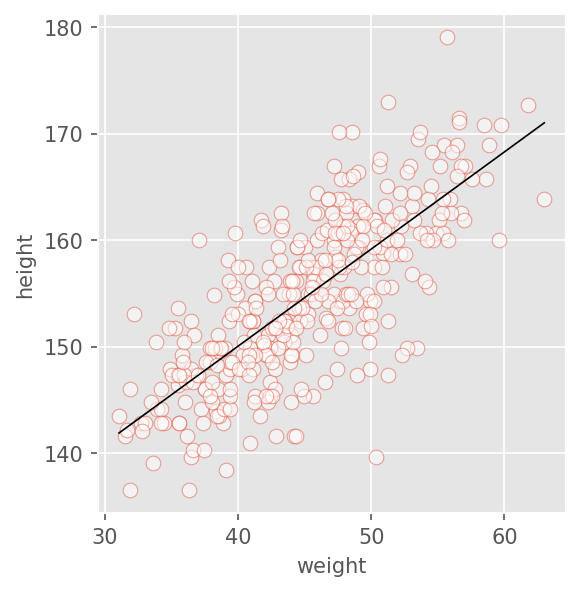

In [57]:
ax = plt.subplot(aspect=0.8)
scatter(d2.weight, d2.height, ax=ax)

post = dotdict(post)
a_map = post.a.mean()
b_map = post.b.mean()
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
ax.plot(w, a_map + b_map*(w-wbar), color="k")

ax.set(xlabel="weight", ylabel="height");

Figure 4.6. Scatterplot of `Howell1` data and the posterior mean height as per `m4_3`.

### Code 4.47 (`m4_3` post sample)
To better appreciate how the posterior distribution contains lines, we work with all the samples from the model.

In [58]:
dframe(post).head()

a         b     sigma
0  154.485413  0.942652  5.311466
1  154.669052  0.934383  4.968511
2  154.602478  0.882515  5.305327
3  154.369583  0.963061  4.944293
4  155.029419  0.877169  4.932331

_4.4.3.3. Adding uncerntainty around the mean._ We start by sampling regression lines from the posterior distribution, and plot them against the raw data. Let's also see how adding in more data reduces the posterior uncertainties of the parameters.

### Code 4.48 (`m4_3` with 10 data points)

In [59]:
N = 10
dN = d2.iloc[:N, ]

mN = AutoLaplaceApproximation(f4_3)
viN = SVI(f4_3, mN, Adam(1), Trace_ELBO())
resN = viN.run(random.PRNGKey(1), 2000, dN.weight.values, dN.height.values)
pN = resN.params
post = mN.sample_posterior(random.PRNGKey(1), pN, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

100%|███████████████████████| 2000/2000 [00:00<00:00, 3732.52it/s, init loss: 1013.7511, avg. loss [1901-2000]: 37.0481]


mean    sd    5.5%   94.5%
a      152.64  1.46  150.23  154.85
b        0.95  0.14    0.72    1.18
sigma    4.68  1.11    3.07    6.51

### Code 4.49 (plot posterior lines from the fit)

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
plt.subplots_adjust(bottom=0.05, right=0.8, top=1.5)

scatter(dN.weight, dN.height, ax[0, 0])
ax[0, 0].set(title="N = 10")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = dotdict(mN.sample_posterior(random.PRNGKey(1), pN, (20,)))
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[0, 0].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k", alpha=0.2)
plt.close()

#### Exercise: plot sampled lines with increasing data points

In [61]:
N = 50
dN = d2.iloc[:N, ]

mN = AutoLaplaceApproximation(f4_3)
viN = SVI(f4_3, mN, Adam(1), Trace_ELBO())
resN = viN.run(random.PRNGKey(1), 2000, dN.weight.values, dN.height.values)
pN = resN.params
post = mN.sample_posterior(random.PRNGKey(1), pN, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

100%|██████████████████████| 2000/2000 [00:00<00:00, 3576.25it/s, init loss: 4898.3945, avg. loss [1901-2000]: 157.5451]


mean    sd    5.5%   94.5%
a      152.79  0.69  151.64  153.85
b        0.90  0.09    0.75    1.05
sigma    4.88  0.50    4.10    5.67

In [62]:
scatter(dN.weight, dN.height, ax[0, 1])
ax[0, 1].set(title="N = 50")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = dotdict(mN.sample_posterior(random.PRNGKey(1), pN, (20,)))
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[0, 1].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k", alpha=0.2)

In [63]:
N = 150
dN = d2.iloc[:N, ]

mN = AutoLaplaceApproximation(f4_3)
viN = SVI(f4_3, mN, Adam(1), Trace_ELBO())
resN = viN.run(random.PRNGKey(1), 2000, dN.weight.values, dN.height.values)
pN = resN.params
post = mN.sample_posterior(random.PRNGKey(1), pN, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

100%|█████████████████████| 2000/2000 [00:00<00:00, 3552.38it/s, init loss: 14893.0098, avg. loss [1901-2000]: 474.4138]


mean    sd    5.5%   94.5%
a      154.31  0.45  153.57  154.99
b        0.90  0.06    0.80    1.01
sigma    5.45  0.32    4.95    5.95

In [64]:
scatter(dN.weight, dN.height, ax[1, 0])
ax[1, 0].set(title="N = 150")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = dotdict(mN.sample_posterior(random.PRNGKey(1), pN, (20,)))
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[1, 0].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k", alpha=0.2)

In [65]:
N = 352
dN = d2.iloc[:N, ]

mN = AutoLaplaceApproximation(f4_3)
viN = SVI(f4_3, mN, Adam(1), Trace_ELBO())
resN = viN.run(random.PRNGKey(1), 4000, dN.weight.values, dN.height.values)
pN = resN.params
post = mN.sample_posterior(random.PRNGKey(1), pN, (4, 1000))
precis(post, pars=["a", "b", "sigma"])

100%|████████████████████| 4000/4000 [00:00<00:00, 5122.48it/s, init loss: 35009.0938, avg. loss [3801-4000]: 1078.9265]


mean    sd    5.5%   94.5%
a      154.60  0.27  154.14  155.01
b        0.91  0.04    0.84    0.97
sigma    5.08  0.19    4.77    5.39

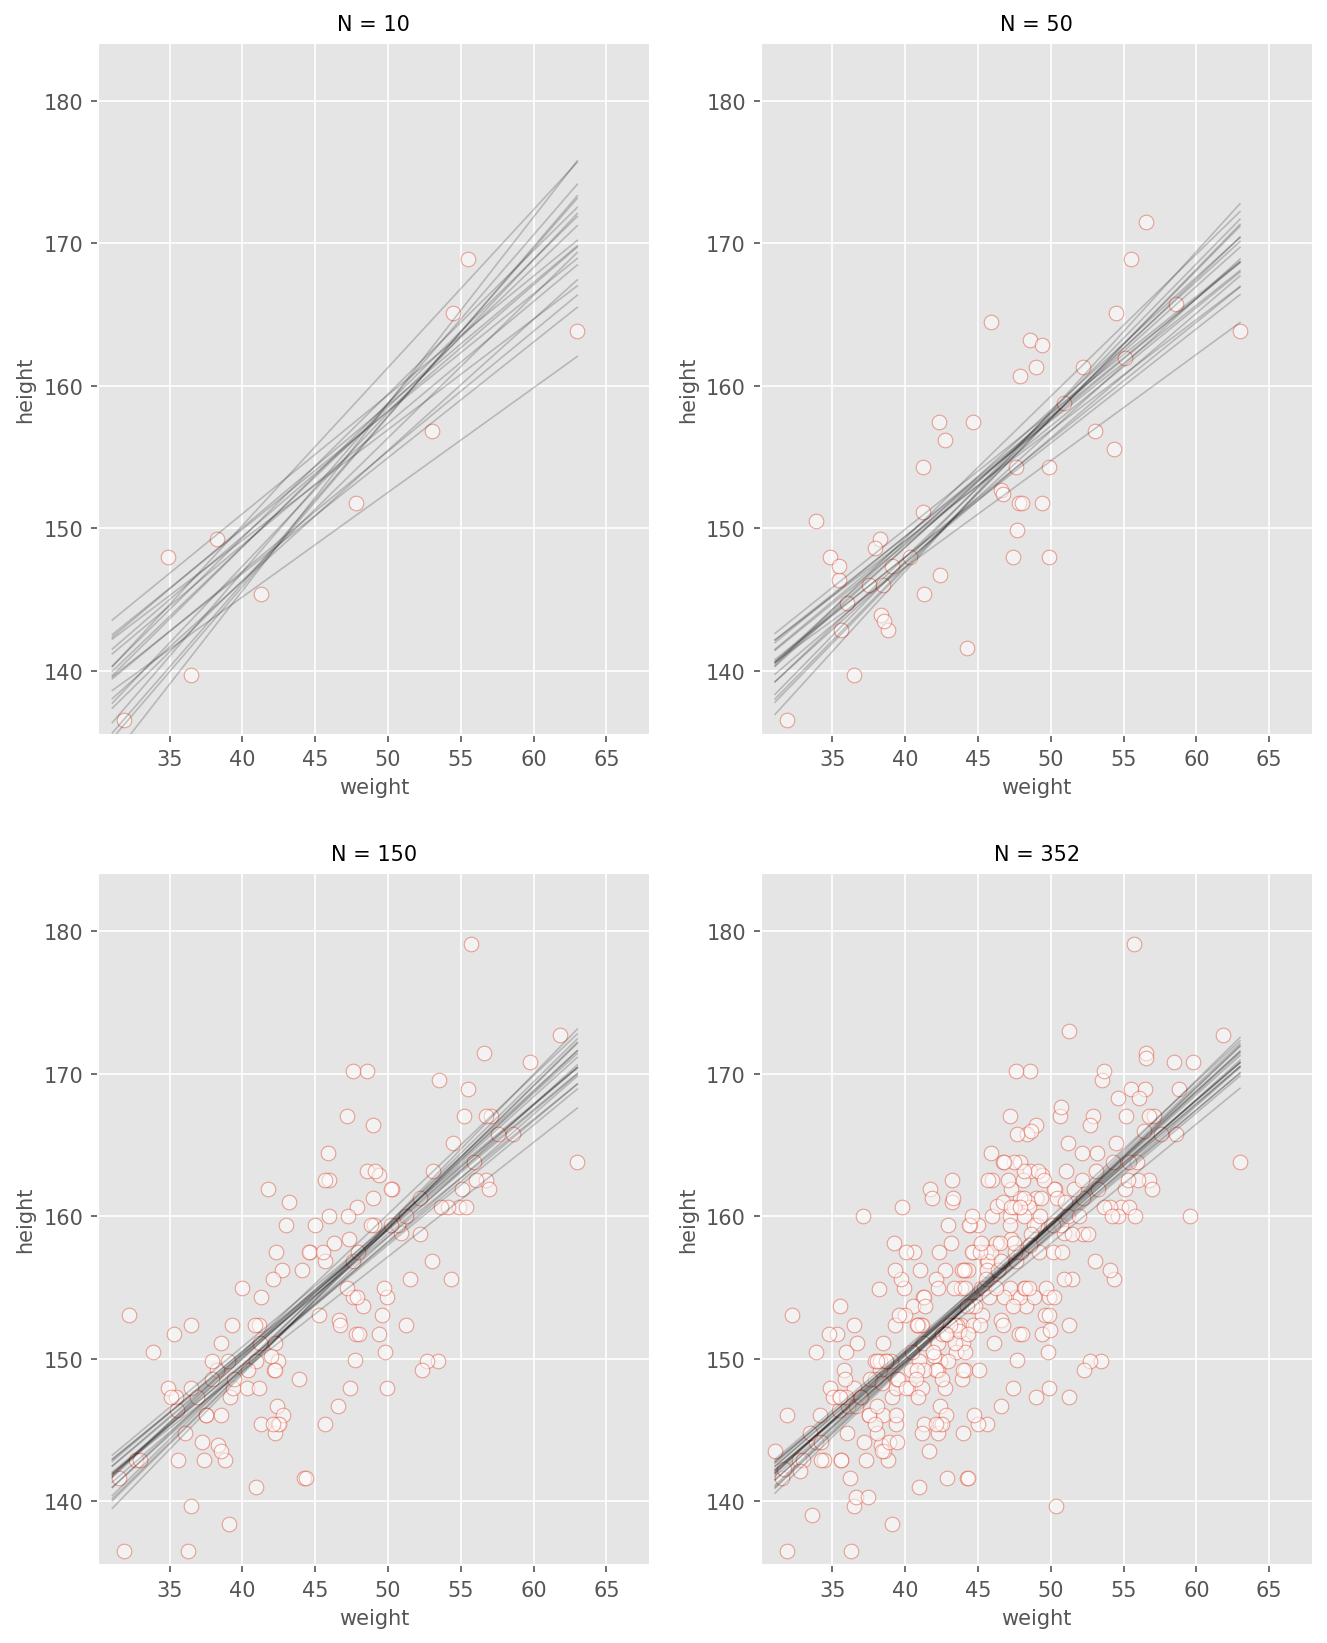

In [66]:
scatter(dN.weight, dN.height, ax[1, 1])
ax[1, 1].set(title="N = 352")
plt.setp(ax, xlabel="weight", ylabel="height",
         xlim=[dN.weight.min() - 1, dN.weight.max() + 5], 
         ylim=[dN.height.min() - 1, dN.height.max() + 5]);

post = dotdict(mN.sample_posterior(random.PRNGKey(1), pN, (20,)))
wbar = d2.weight.mean()
w = np.linspace(d2.weight.min(), d2.weight.max())
for i in range(20):
    ax[1, 1].plot(w, post.a[i] + post.b[i]*(w-wbar), color="k", alpha=0.2)
fig

Figure 4.7. Samples from the quadratic approximate posterior for `m4_3` with increasing amounts of data.

_4.4.3.4. Plotting regression intervals and contours._

It's much clearer and more common to visualize uncertainty by plotting an interval or contour around the mean regression line.

### Code 4.50 (sample mean predictions for a particular value of weight)

In [67]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (10000,))
post = dotdict(post)
mu_at_50 = post.a + post.b*(50 - wbar)

### Code 4.51 (density plot of the mean prediction samples) 

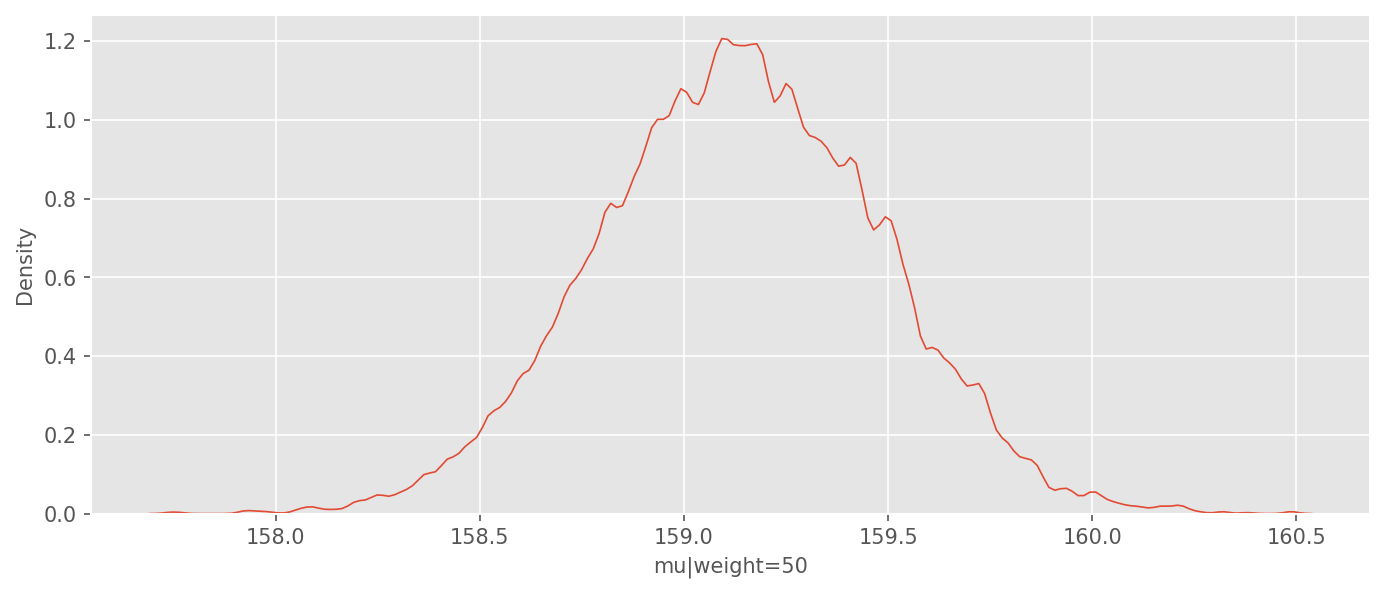

In [68]:
ax = plt.subplot()
sns.kdeplot(mu_at_50, bw_adjust=.3)
ax.set_xlabel("mu|weight=50");

Figure 4.8. The quadratic approximate posterior of the mean height when weight is 50 kg. 
This distribution represents the relative plausibility of different values of the mean.

### Code 4.52 (hdi of the mean prediction)

In [69]:
hpdi(mu_at_50, prob=.89)

array([158.59212, 159.68742], dtype=float32)

### Code 4.53 (sample post pred of mu given data)

In [70]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
ppd = Predictive(f4_3, post, return_sites=["mu"], batch_ndims=1)
mu = ppd(random.PRNGKey(2), w=d2.weight.values, h=d2.height.values)["mu"]
mu.shape, mu[:5, 0]

((1000, 352),
 Array([157.12938, 157.30838, 157.05736, 156.90125, 157.4044 ], dtype=float32))

### Code 4.54 (sample post pred of mu given seq of w)

In [71]:
weight_seq = jnp.arange(25, 71, 1)
mu = ppd(random.PRNGKey(2), w=weight_seq, h=None)["mu"]
mu.shape, mu[:5, 0]

((1000, 46),
 Array([132.43663, 134.76   , 136.30734, 135.78668, 131.76733], dtype=float32))

### Code 4.55 (plot 100 sampled mean pred for each weight)

In [72]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(d2.weight.values, d2.height.values, alpha=0)
plt.setp(ax, xlabel="weight", ylabel="height")

for i in range(100):
    ax[0].plot(weight_seq, mu[i], ".", alpha=0.05, c="C0")
plt.close()

See the left of Figure 4.9.

### Code 4.56 (summarize sampled mean pred)

In [73]:
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, prob=.89)

### Code 4.57 (plot hdi)

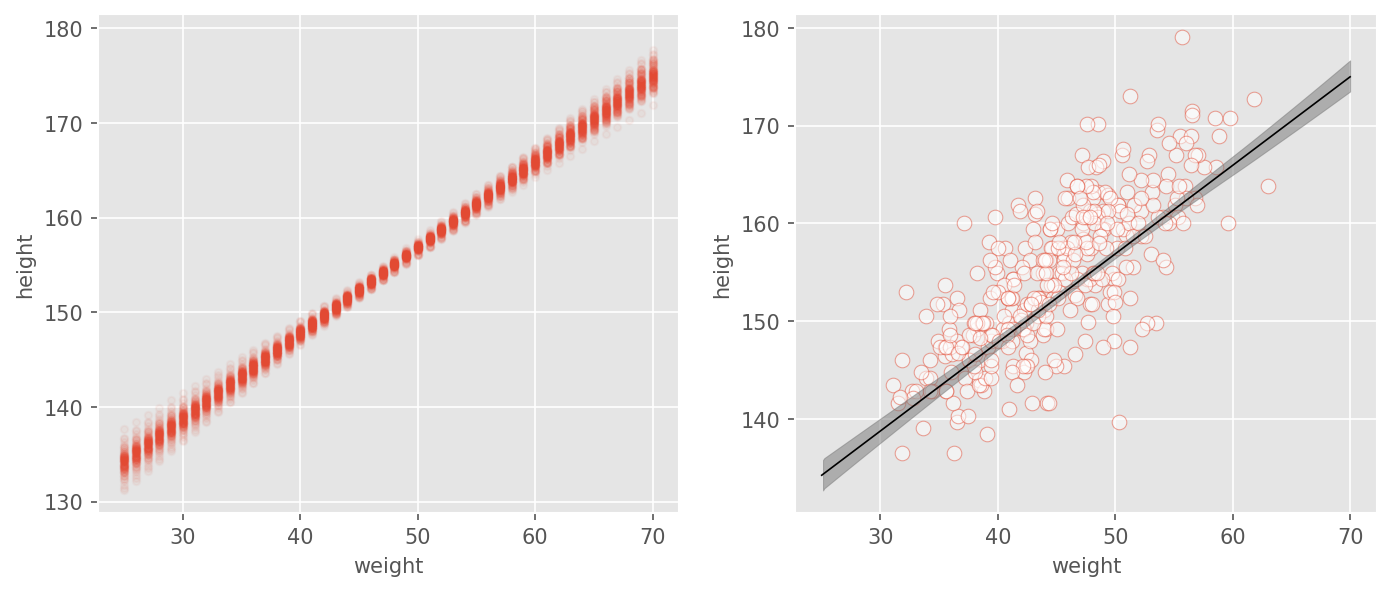

In [74]:
scatter(d2.weight, d2.height, ax=ax[1])
ax[1].plot(weight_seq, mu_mean, c="k")
az.plot_hdi(weight_seq, mu_PI, color="C3", ax=ax[1])
fig

Figure 4.9. Left: the first 100 values in the posterior of `mu` at each weight. Right: 89% HPDI of the mean indicated by the shaded region. Compare this region to the distributions of the points on the left.

The plotting of the plausibility intervals reaches a broader evidence, even if doing the math to get those intervals is possible for quadratic approximation (maybe Gaussian VI too). Importantly, you should always know how the model relates to the data, to produce sensible plots.

**Rethinking: Overconfident confidence intervals.** With 352 data points from the `Howell1` dataset, and our height-weight regression model, we managed to get a tight HDI for our posterior regression lines. But remember these confidence intervals are always conditioned on the model. Even a very bad model can have very tight intervals. You should always say: _Conditional on the assumption that height and weight are related by a straight line, then the lines within the shaded region are most plausible._

**Overthinking: How `link` works.** The `link` function refers to a function from the original `rethinking` package that handles the dimensions issues during prediction sampling, like distinguishing the sample axis from the batch axis (# of data points). 

Python-based PPL packages tend to have similar built-in functionalities. For Numpyro and PyMC, we can register any variable as a deterministic function of other random variables and later explicitly tell these packages to sample the registered variable (`numpyro.infer.Predictive(..., return_sites=["mu"])` for Numpyro, `pm.sample_posterior_predictive(..., var_names=["mu"])` for PyMC). 

We also run into a problem where we would like to sample the registered variable based on an arbitrary set of exogenous inputs, not on those inputs from the data. Numpyro's `Predictive` instances provide a simplistic interface where you just need to pass in the inputs you want when calling the instances for sampling predictions, as long as you pass in the correct `batch_ndims` when instantiating this class to avoid confusing the batch axis with the sample axis. PyMC utilizes `pytensor.shared` with which you can register the changable inputs as shared tensors, and explicitly declaring the shape of the output to be the same as those changeable inputs. A shared tensor has a `set_value` method where a new input of arbitrary length can be passed in, and is ought to be called before calling `pm.sample_posterior_predictive()`.

Let's manually implement this thing. 

### Code 4.58 (implementing `link` with `jax.vmap`)

In [75]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - wbar)
weight_seq = jnp.arange(25, 71, 1)
mu = vmap(mu_link, 0, 1)(weight_seq)
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, .89)

Knowing this manual method makes you more flexible to calculate whatever values based on posterior sampling. Automated tools are great, but they are never as flexible as your own code.  

_4.4.3.5. Prediction intervals._ The actual height depends on both the mean height and the modeled variance.

### Code 4.59 (sampling height pred)

In [76]:
ppd = Predictive(f4_3, post, return_sites=["h"], batch_ndims=1)
sim_height = ppd(random.PRNGKey(5), w=weight_seq, h=None)["h"]
sim_height.shape, sim_height[:5, 0]

((1000, 46),
 Array([131.08578, 140.47635, 137.91783, 140.65784, 141.99838], dtype=float32))

### Code 4.60 (hpdi of height pred)

In [77]:
height_PI = hpdi(sim_height, .89)

Let's plot everything we built up for `weight_seq`: (1) the average line, (2) the shaded region of 89% plausible `mu`, and (3) the 89% plausible simulated heights.

### Code 4.61 (plot hpdi of height pred)

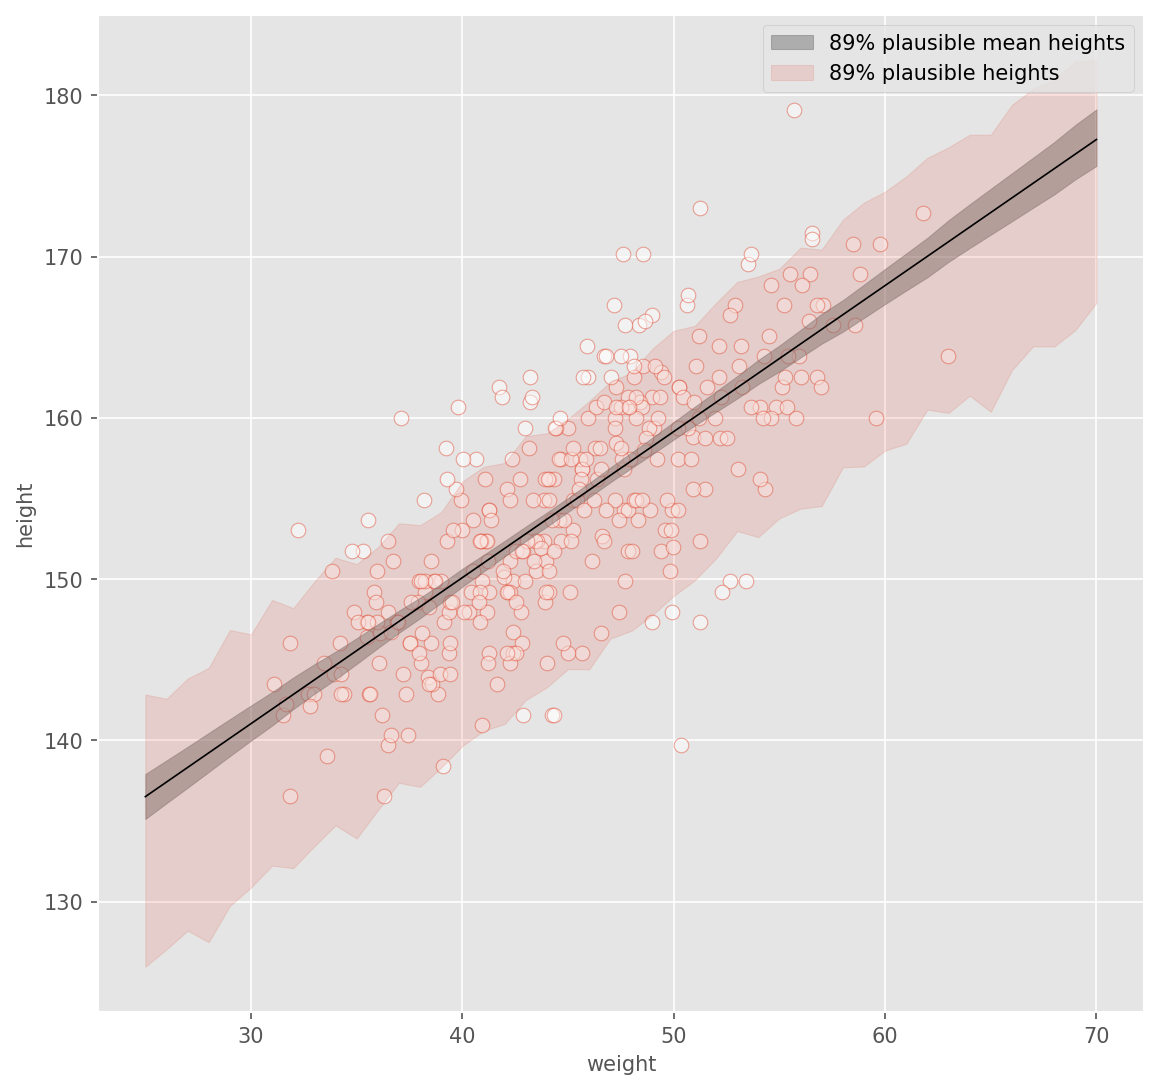

In [78]:
fig, ax = plt.subplots(figsize=(9, 7))
scatter(d2.weight, d2.height, ax=ax)
ax.plot(weight_seq, mu_mean, c="k")
ax.fill_between(weight_seq, mu_PI[0], mu_PI[1], 
                color="C3", alpha=.5, label="89% plausible mean heights")
ax.fill_between(weight_seq, height_PI[0], height_PI[1], 
                color="C0", alpha=.15, label="89% plausible heights")
ax.set(xlabel="weight", ylabel="height")
ax.legend();

Figure 4.10. 89% prediction interval of height. The two shaded regions indicate plausibility intervals of two different variables. 

#### Exercise: also plot 67% and 97% plausible regions of heights

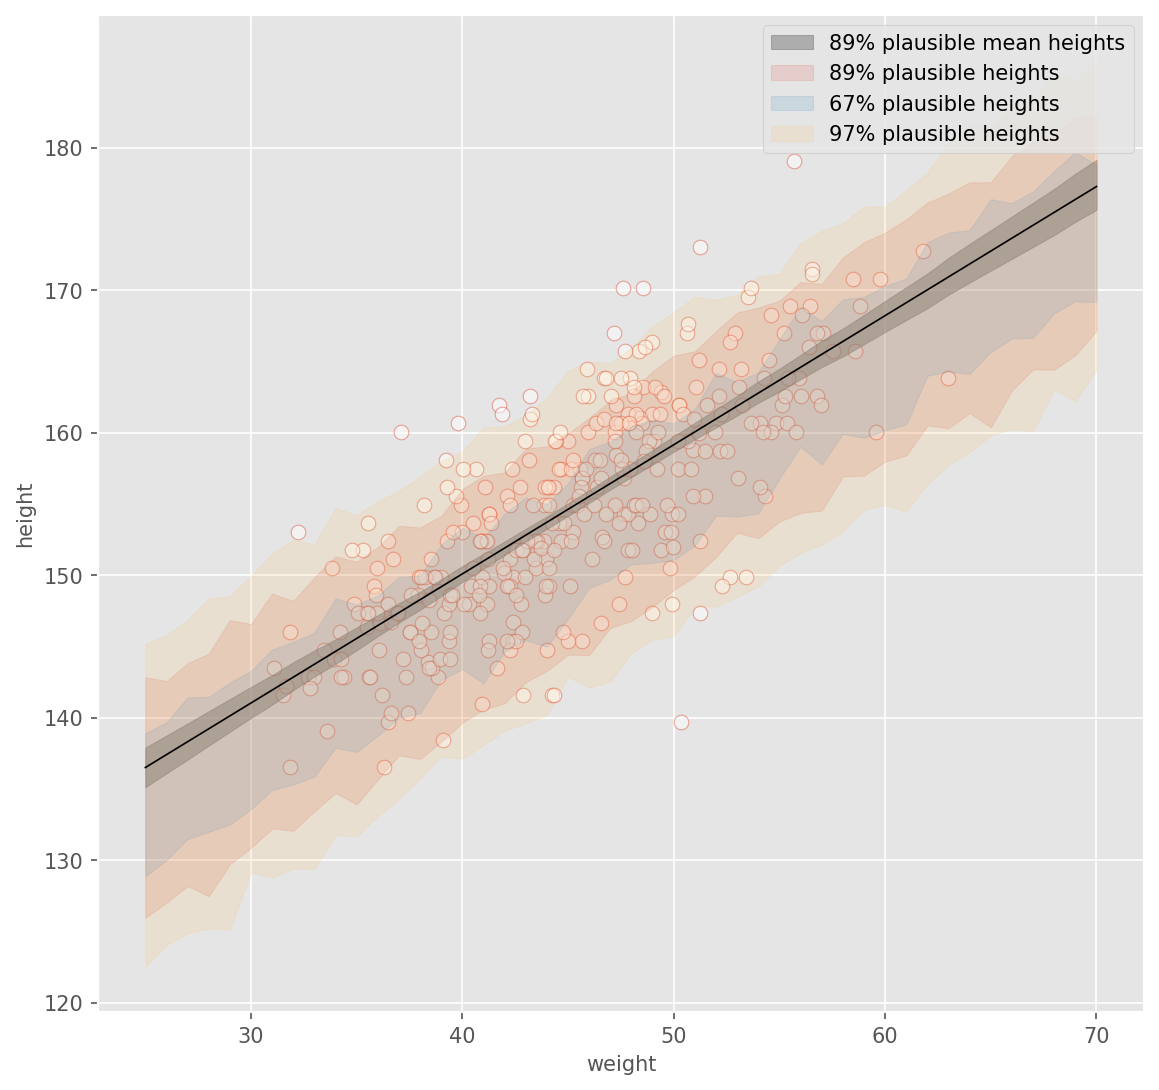

In [79]:
height_PI1 = hpdi(sim_height, .67)
ax.fill_between(weight_seq, height_PI1[0], height_PI1[1], 
                color="C1", alpha=.15, label="67% plausible heights")

height_PI2 = hpdi(sim_height, .97)
ax.fill_between(weight_seq, height_PI2[0], height_PI2[1], 
                color="C4", alpha=.15, label="97% plausible heights")
ax.legend()
fig

Notice the roughness of all these plausibility regions. If that bothers you, increase the number of samples you take from the posterior. 

### Code 4.62 (sample heights again but more)

In [80]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (int(1e4),))
ppd = Predictive(f4_3, post, return_sites=["h"], batch_ndims=1)
sim_height = ppd(random.PRNGKey(1), w=weight_seq, h=None)["h"]
height_PI = hpdi(sim_height, .89)

#### Exercise: plot the plausibility region of height again

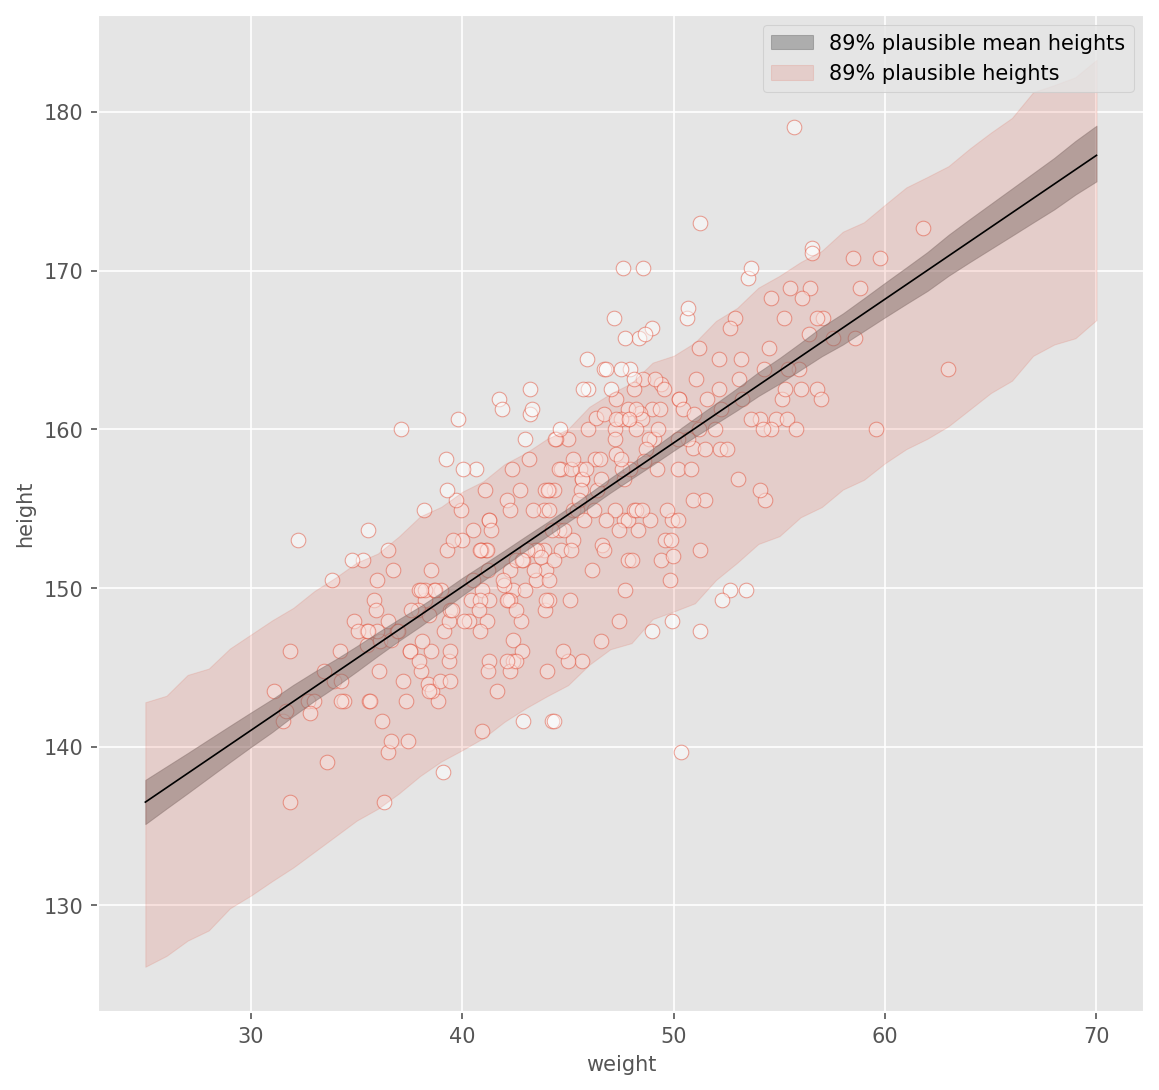

In [81]:
fig, ax = plt.subplots(figsize=(9, 7))
scatter(d2.weight, d2.height, ax=ax)
ax.plot(weight_seq, mu_mean, c="k")
ax.fill_between(weight_seq, mu_PI[0], mu_PI[1], 
                color="C3", alpha=.5, label="89% plausible mean heights")
ax.fill_between(weight_seq, height_PI[0], height_PI[1], 
                color="C0", alpha=.15, label="89% plausible heights")
ax.set(xlabel="weight", ylabel="height")
ax.legend();

It can be hard to get rid of the roughness. Luckily it hardly matters, except for aesthetics. Moreover, it serves to remind us that all statistical inference is approximate. 

**Rethinking: Two kinds of uncertainty.** We have encountered both uncertainty in parameter values and uncertainty in a sampling process. The cloud of lines, the overlaying points, and the plausibility regions do include both kinds of uncertainty. And the sampling uncertainty is still a model assumption. It's no more or less objective than the posterior itself. Furthermore, it's possible to view the Gaussian likelihood as a purely epistemological assumption (a device for estimating the mean and variance of a variable), rather than an ontological one about what future data will look like. _In that case, it may not make complete sense to simulate outcomes._

**Overthinking: Rolling your own `sim`.** Just like `link`, we can manually implement `sim`.

### Code 4.63 (implement `sim` with `jax.vmap` and `numpyro.dist.Normal`)

In [82]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71, 1)
sim_height_vmap = vmap(lambda i, w: dist.Normal(
                          post["a"] + post["b"]*(w - wbar), post["sigma"]
                        ).sample(random.PRNGKey(i))
                       , 0, 1)
sim_height = sim_height_vmap(jnp.arange(len(weight_seq)), weight_seq)
height_PI = hpdi(sim_height, .89)

---
## Section 4.5 Curves from lines

The models we explored so far all use a straight line to describe the relationship between two variables. But there's nothing special about straight lines except for the simplicity. Now we will consider how to build curves for describing associations between two variables. The first is **polynomial regression**, and the second is **B-splines**.

**4.5.1. Polynomial regression.** Understanding how this type of regression works will help scaffold later models.

### Code 4.64 (read `Howell1` data)

This time we're studying all individuals in the data, not just those with age >= 18. 

In [83]:
d = data("Howell1")
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

From the scatter plot below of weight v. height, we can see that the relationship is visibly curved when we included the non-adult individuals.

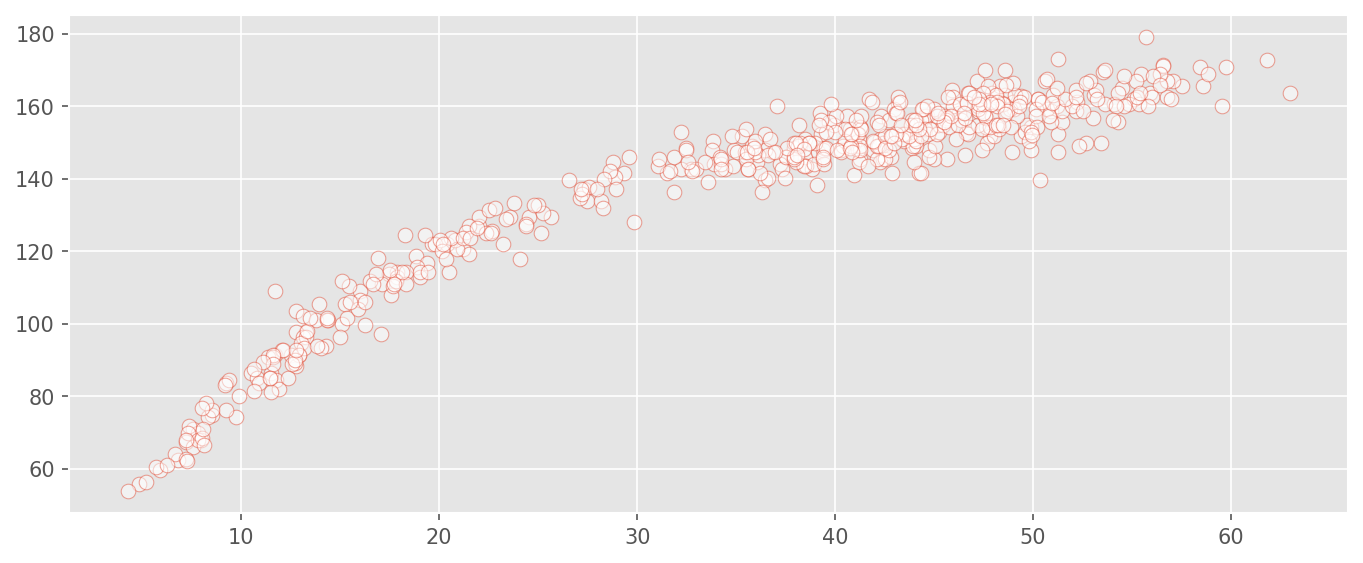

In [84]:
ax = plt.subplot()
scatter(d.weight, d.height, ax);

The most common polynomial regression is a parabolic model of the mean. Fitting this model is easy. Interpreting it can be hard. Let's just do the easy part first. We should always check if the predictor variables are standardized for these parametric models, especially for polynomial regressions. Otherwise, numerical instability can happen if we elevate the order of some large numbers.

Here's the model:

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_1 x_i + \beta_2 x^2_i$$
$$\alpha \sim \text{Normal}(178, 20)$$
$$\beta_1 \sim \text{LogNormal}(0, 1)$$
$$\beta_2 \sim \text{Normal}(0, 1)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

We do not want a positive constraint for $\beta_2$. In the problems at the end of the chapter, you'll use prior predictive simulation to understand why. These polynomial parameters are in general hard to set realistic priors for, which is another reason to avoid polynomial models.

### Code 4.65 (standardizing & built quad model)

As said before, we should standardize our predictor (weight), and then sqaure it to get the 2nd order term.

In [85]:
d["weight_s"] = scale(d.weight)
d["weight_s2"] = d.weight_s ** 2

def f4_5(h, w, w2):
    a = sample("a", dist.Normal(178, 20))
    b1 = sample("b1", dist.LogNormal(0, 1))
    b2 = sample("b2", dist.Normal(0, 1))
    sigma = sample("sigma", dist.Uniform(0, 50))
    if w2 is None: w2 = 0
    mu  = deterministic("mu", a + b1*w + b2*w2)
    height = sample("h", dist.Normal(mu, sigma), obs=h)
    
m4_5 = AutoLaplaceApproximation(f4_5)
vi4_5 = SVI(f4_5, m4_5, Adam(0.5), Trace_ELBO(), 
            h=d.height.values, w=d.weight_s.values, w2=d.weight_s2.values)
seed = random.PRNGKey(0)
res4_5 = vi4_5.run(seed, 16000)
p4_5 = res4_5.params
post = m4_5.sample_posterior(seed, p4_5, (4, 1000))

100%|████████████████| 16000/16000 [00:02<00:00, 6949.87it/s, init loss: 68267.6406, avg. loss [15201-16000]: 1771.0579]


### Code 4.66 (summarize quad model)

It is not easy to read the relationships off a table of coefficients, because the `height` and `weight` relationship now depend on two slopes.

In [86]:
precis(post, pars=["a", "b1", "b2", "sigma"])

mean    sd    5.5%   94.5%
a      146.06  0.36  145.50  146.67
b1      21.58  0.29   21.14   22.07
b2      -7.80  0.27   -8.21   -7.36
sigma    5.74  0.18    5.46    6.02

The `a` is still representing the expected height if the weight is at its mean value, but now it is not the same as the mean height in the sample, as it is generally not the case for polynomial regression. 

An intuitive explanation is that $\alpha = \mathbb{E}y - \beta_1\mathbb{E}x_i - \beta_2\mathbb{E}x_i^2$. Even assuming $\mathbb{E}x_i = 0$, then generally $\mathbb{E}x_i^2$ won't be zero. 

We can think of $\beta_1, \beta_2$ as the linear and square components of the curve, but that doesn't make them transparent. You'll have to plot these model fits to understand what they are saying. 

### Code 4.67 (sample mean & height preds)

In [87]:
weight_seq = jnp.linspace(-2.2, 2, 30)
post = m4_5.sample_posterior(seed, p4_5, (1000,))
ppd = Predictive(f4_5, post, return_sites=["mu", "h"], batch_ndims=1)
ppd_res = ppd(seed, w=weight_seq, w2=weight_seq**2, h=None)
mu, sim_height = ppd_res["mu"], ppd_res["h"]
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, .89)
height_PI = hpdi(sim_height, .89)

### Code 4.68 (plot mean & height preds from quad model)

See Figure 4.11 middle.

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
plt.setp(ax, xlabel="weight_s", ylabel="height")
for a in ax:
    scatter(d.weight_s, d.height, ax=a)
ax[1].plot(weight_seq, mu_mean, c="k")
ax[1].fill_between(weight_seq, mu_PI[0], mu_PI[1], color="C3", alpha=0.5)
ax[1].fill_between(weight_seq, height_PI[0], height_PI[1], color="C2", alpha=0.3)
ax[1].set(title="quadratic")
plt.close();

#### Plot linear model again

See Figure 4.11 left.

In [89]:
m4_5a = AutoLaplaceApproximation(f4_5)
vi4_3a = SVI(f4_5, m4_5a, Adam(.1), Trace_ELBO())
res4_3a = vi4_3a.run(seed, 16000, 
                     w=d.weight_s.values, w2=None, h=d.height.values)
p4_3a = res4_3a.params
post4_3a = m4_5a.sample_posterior(seed, p4_3a, (4,1000))
precis(post4_3a, pars=["a", "b1", "sigma"])

100%|████████████████| 16000/16000 [00:02<00:00, 7141.58it/s, init loss: 67190.4062, avg. loss [15201-16000]: 2002.6366]


mean    sd    5.5%   94.5%
a      138.28  0.40  137.67  138.94
b1      25.95  0.41   25.30   26.60
sigma    9.35  0.29    8.88    9.79

In [90]:
post4_3a = m4_5a.sample_posterior(seed, p4_3a, (1000,))
ppd = Predictive(f4_5, post, return_sites=["mu", "h"], batch_ndims=1)
ppd_res = ppd(seed, w=weight_seq, w2=None, h=None)
mu, sim_height = ppd_res["mu"], ppd_res["h"]
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, .89)
height_PI = hpdi(sim_height, .89)

ax[0].plot(weight_seq, mu_mean, c="k")
ax[0].fill_between(weight_seq, mu_PI[0], mu_PI[1], color="C3", alpha=0.5)
ax[0].fill_between(weight_seq, height_PI[0], height_PI[1], color="C2", alpha=0.3)
ax[0].set(title="linear");

### Code 4.69 (cubic model)

In [91]:
d["weight_s3"] = d.weight_s**3


def f4_6(h, w, w2=0, w3=0):
    a = sample("a", dist.Normal(178, 20))
    b1 = sample("b1", dist.LogNormal(0, 1))
    b2 = sample("b2", dist.Normal(0, 1))
    b3 = sample("b3", dist.Normal(0, 1))
    sigma = sample("sigma", dist.Uniform(0, 50))
    mu  = deterministic("mu", a + b1*w + b2*w2 + b3*w3)
    height = sample("h", dist.Normal(mu, sigma), obs=h)
    
m4_6 = AutoLaplaceApproximation(f4_6)
vi4_6 = SVI(f4_6, m4_6, Adam(0.5), Trace_ELBO(), 
            h=d.height.values, w=d.weight_s.values, 
            w2=d.weight_s2.values, w3=d.weight_s3.values)
seed = random.PRNGKey(0)
res4_6 = vi4_6.run(seed, 16000)
p4_6 = res4_6.params
post = m4_6.sample_posterior(seed, p4_6, (4, 1000))

precis(post, pars=["a", "b1", "b2", "b3", "sigma"])

100%|█████████████████| 16000/16000 [00:02<00:00, 7175.20it/s, init loss: 5544.0449, avg. loss [15201-16000]: 1669.0780]


mean    sd    5.5%   94.5%
a      146.43  0.30  145.93  146.90
b1      14.88  0.51   14.14   15.75
b2      -6.18  0.25   -6.62   -5.80
b3       3.58  0.24    3.19    3.95
sigma    4.75  0.14    4.51    4.96

#### Plotting the cubic curve

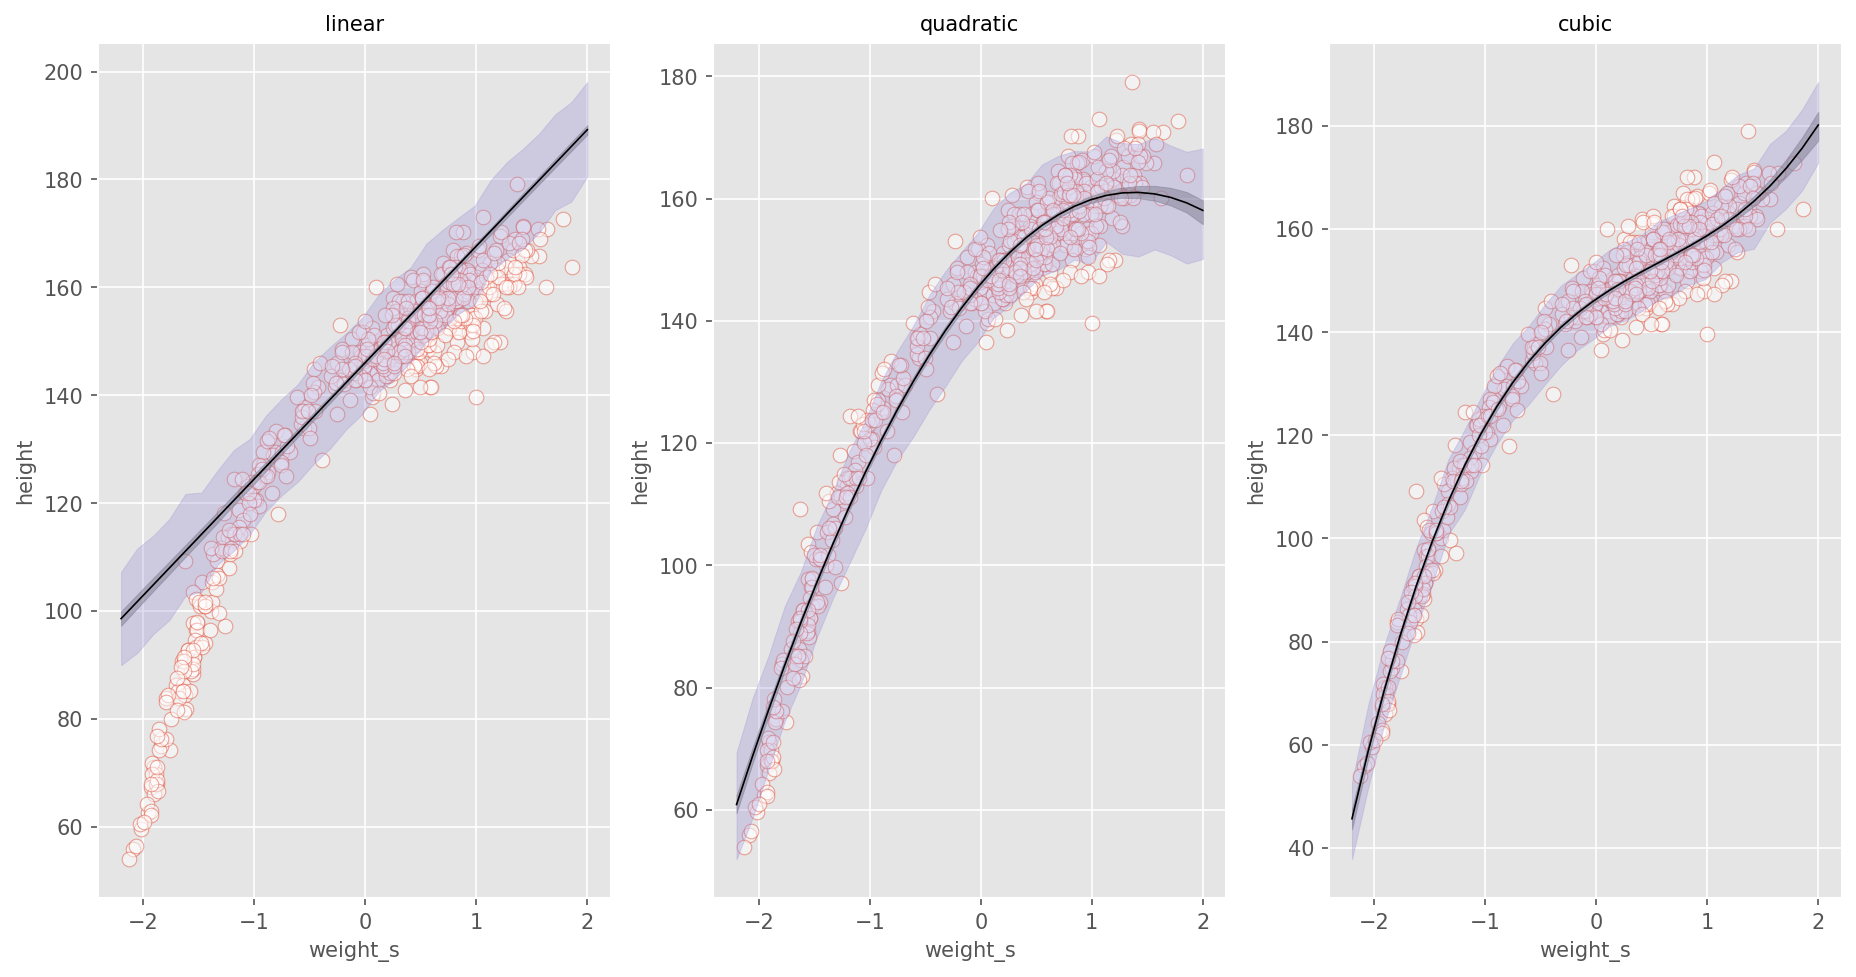

In [92]:
post4_6 = m4_6.sample_posterior(seed, p4_6, (1000,))
ppd = Predictive(f4_6, post4_6, return_sites=["mu", "h"], batch_ndims=1)
ppd_res = ppd(seed, w=weight_seq, w2=weight_seq**2, w3=weight_seq**3, h=None)
mu, sim_height = ppd_res["mu"], ppd_res["h"]
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, .89)
height_PI = hpdi(sim_height, .89)

ax[2].plot(weight_seq, mu_mean, c="k")
ax[2].fill_between(weight_seq, mu_PI[0], mu_PI[1], color="C3", alpha=0.5)
ax[2].fill_between(weight_seq, height_PI[0], height_PI[1], color="C2", alpha=0.3)
ax[2].set(title="cubic");
fig

Figure 4.11. Linear, quadratic, and cubic regression models of height v. weight (standardized). The solid lines are the expected mean heights, the tight, grey intervals are the 89% plausibility intervals for the mean heights, and the blue intervals are the 89% plausibility intervals for the actual heights.

A cubic curve is more flexible, so it can fit the data even better. But it's not clear that any of these models make a lot of sense. They are good models for height prediction, but there are two problems. First, overfitting (Chapter 7). Second, we aren't learning anything about any causal relationship between height and weight (Chapter 16).

**Rethinking: Linear, additive, funky.** All three models above are actually still "linear" in a sense. Unfortunately, the world "linear" means different things given different contexts and different people. But all these models are additive, linear models, often used. We should feel embarassed to use them, just so we don't become satisfied with the phenomenological explanations they provide.

**Overthinking: Converting back to natural scale.** Suppose you want to plot the estimates on the original scale, you will turn off the `xticks` and create your own.

### Code 4.70 (plot and delete xticks)

In [93]:
ax = plt.subplot()
scatter(d.weight_s, d.height, ax)
ax.set(xticks=[], xlabel="weight", ylabel="height")
fig = plt.gcf()
plt.close()

### Code 4.71 (add your xticks)

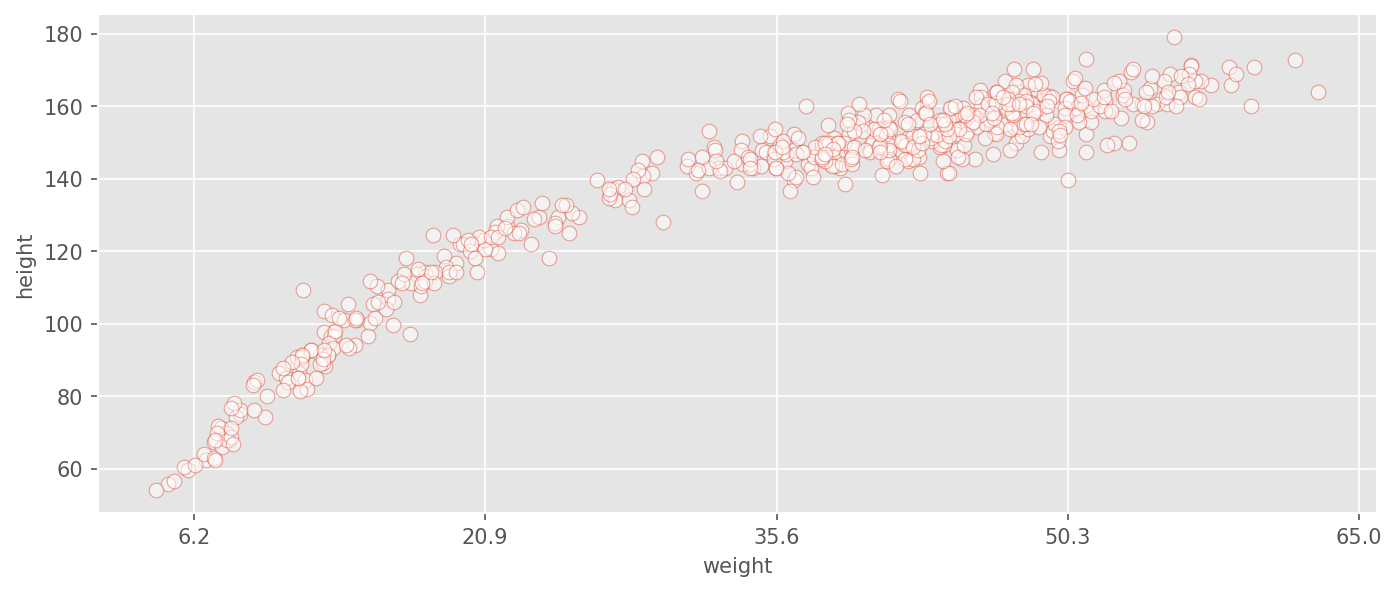

In [94]:
at = np.array([-2, -1, 0, 1, 2])
labels = at*d.weight.std() + d.weight.mean()
ax.set(xticks=at, xticklabels=labels.round(1))
fig

**4.5.2 Splines.** Splines are smooth, continuous functions made up of smaller component functions. There are many types of splines, and we are looking at the most common ones, the **B-splines**. The "B" stands for "basis". They are here to built wiggly curves, although they are less wiggly on their own. 

To see how this works, we need an example that is much wigglier. Cherry trees blossom all over Japan in the spring each year. Let's load a thousand years of Japanese cherry blossom dates:

### Code 4.72 (read cherry data)

In [95]:
d = data("cherry_blossoms", delim=",")
precis(d)

mean      sd    5.5%    94.5%
year        1408.00  350.88  867.77  1948.23
doy          104.54    6.41   94.43   115.00
temp           6.14    0.66    5.15     7.29
temp_upper     7.19    0.99    5.90     8.90
temp_lower     5.10    0.85    3.79     6.37

We are working with `temp` and `year` now. Let's plot them.

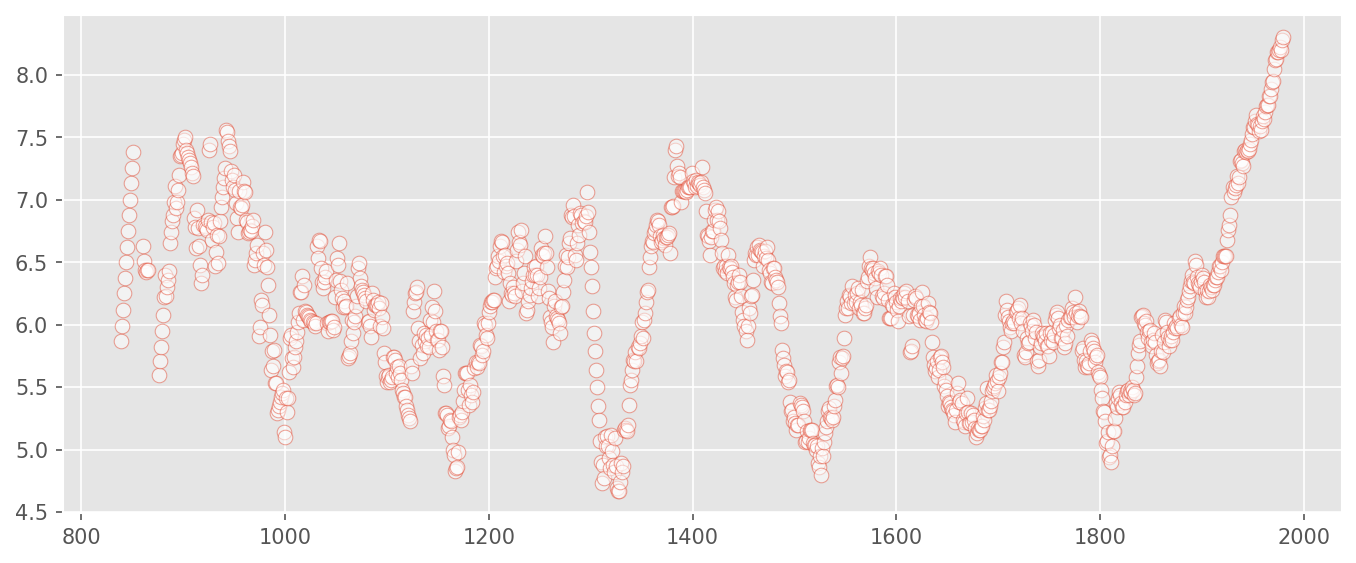

In [96]:
ax = plt.subplot()
scatter(d.year, d.temp, ax);

No parabolic curve can do the job here. But B-splines can. B-splines transform the raw predictor variables into a set of new, synthetic variables to turn on and off specific parameters:

$$\mu_i = \alpha + w_1B_{i, 1} + w_2B_{i, 2} + w_3B_{i, 3} + ...$$

These synthetic variables can do some really elegant geocentric work for us.

How to construct these basis variables and calculate the overall spline response? See Figure 4.12 below:

![Figure 4.12](../images/b-spline-piecewise-linear.png)

So it is not a particular good fit. To get better, we can add more knots, and get more flexible basis functions (higher degree polynomials, for example). 

Now, let's reproduce and improve the spline with code.

### Code 4.73 (define 15 knots)

In [97]:
d2 = d[d.temp.notna()]
num_knots = 15
knot_list = d.year.quantile(np.linspace(0, 1, num_knots)).values

The next change is the polynomial degree of each basis. For degree 1, as shown in Figure 4.12, 2 bases combine at each year. For degree 2, three bases. For degree 3, four.

### Code 4.74 (get cubic B-splines)

In [98]:
from scipy.interpolate import BSpline

knots = np.pad(knot_list, (2, 2), mode="edge")
B = BSpline(knots, np.eye(num_knots + 2), k=3)(d2.year.values)
B.shape

(1124, 17)

### Code 4.75 (plot cubic bases)

See Figure 4.13 top.

In [99]:
fig, ax = plt.subplots(3, 1, figsize=(9, 9))
plt.setp(ax, xlim=(d2.year.min(), d2.year.max()),
         xlabel="year")

ax[0].set(ylabel="basis value")
for i in range(B.shape[1]):
    ax[0].plot(d2.year, B[:, i], c="k", alpha=0.7)
plt.close()

Now to get the parameters of the bases, we need to define a model and fit it. This is just a linear regression at this point, with each basis as a variable.

Here's out model:

$$T_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \sum^K_{k=1} w_kB_{k, i}$$
$$\alpha \sim \text{Normal}(6, 10)$$
$$w_j \sim \text{Normal}(0, 1)$$
$$\sigma \sim \text{Exponential}(1)$$

We will simulate from these priors in the end-of-chapter problems. Here's our code for the model:

### Code 4.76 (B-spline reg model with GVI)

In [100]:
def f4_7(B, T):
    a = sample("a", dist.Normal(6, 10))
    w = sample("w", dist.Normal(0, 1).expand(B.shape[1:]))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + B @ w)
    sample("T", dist.Normal(mu, sigma), obs=T)
    
m4_7 = AutoLaplaceApproximation(f4_7)
vi4_7 = SVI(f4_7, m4_7, Adam(1), Trace_ELBO(), 
            B=B, T=d2.temp.values)
p4_7 = vi4_7.run(seed, 2000).params

100%|████████████████████| 2000/2000 [00:00<00:00, 3451.82it/s, init loss: 272648.0312, avg. loss [1901-2000]: 497.8323]


In [101]:
post4_7 = m4_7.sample_posterior(seed, p4_7, (4, 1000))
precis(post4_7, pars=["a", "w"])

mean    sd  5.5%  94.5%
a      6.29  0.26  5.88   6.70
w[0]  -0.12  0.28 -0.55   0.32
w[1]   1.43  0.28  0.99   1.87
w[2]  -0.40  0.27 -0.82   0.05
w[3]   0.26  0.27 -0.17   0.68
w[4]  -1.55  0.27 -1.99  -1.12
w[5]   1.15  0.27  0.71   1.57
w[6]  -1.79  0.27 -2.21  -1.34
w[7]   2.08  0.27  1.68   2.54
w[8]  -1.89  0.27 -2.30  -1.44
w[9]   0.67  0.27  0.27   1.12
w[10] -1.41  0.27 -1.84  -0.98
w[11]  0.12  0.27 -0.30   0.55
w[12] -1.23  0.27 -1.67  -0.81
w[13]  0.59  0.28  0.15   1.02
w[14]  2.12  0.27  1.70   2.55
w[15]  0.00  1.00 -1.61   1.58
w[16]  0.01  0.99 -1.55   1.62

We can see the intercept and the 17 `w` parameters, but can't tell what the model thinks from the table unless we plot the posterior predictions. First, here are the weighted basis functions:

### Code 4.77 (plot cubic weighted bases) 

See Figure 4.13 middle.

In [102]:
w = post4_7["w"].mean([0, 1])
ax[1].set(ylim=[-2, 2], ylabel = "basis * weight")

for i in range(B.shape[1]):
    ax[1].plot(d2.year, w[i]*B[:, i], c="k", alpha=0.7) 

And finally the 97% posterior interval for `mu` at each year:

### Code 4.78 (plot cubic B-spline posterior mu)

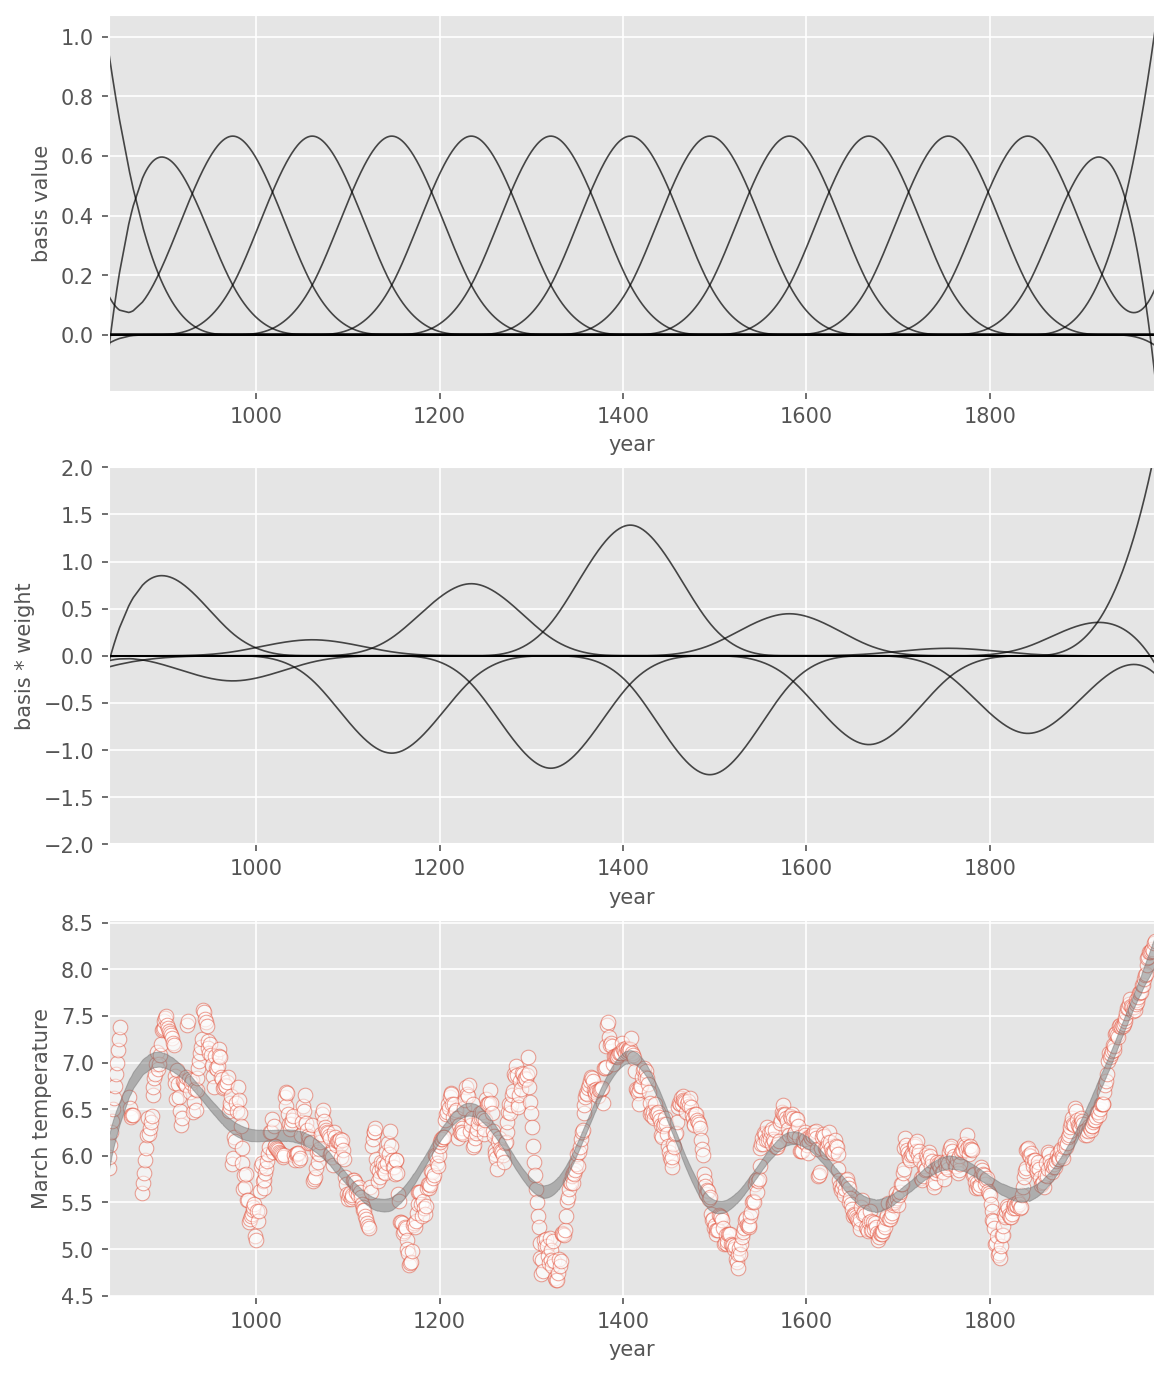

In [104]:
ppd = Predictive(f4_7, post4_7, return_sites=["mu"], batch_ndims=2)
mu = ppd(seed, B=B, T=None)["mu"]
mu = mu.reshape(-1, mu.shape[-1])
mu_PI = hpdi(mu, .89)
scatter(d2.year, d2.temp, ax=ax[2])
ax[2].fill_between(d2.year, mu_PI[0], mu_PI[1], color="C3", alpha=.5)
ax[2].set(ylabel="March temperature")
fig

Figure 4.13. Top: Cubic bases. Middle: Cubic bases weighted by the parameters valued at their posterior means. Bottom: 97% plausibility regions of the B-spline model predictions.

---
## Section 4.6 Summary

This chapter introduced the simple linear regression model. The Gaussian distribution comprises the likelihood in such models, because it counts up the relative numbers of ways means and variances can produce an observation. To fit these Bayesian models, we used quadratic approximation (whisper: with Numpyro's `SVI` and `AutoLaplaceApproximation` guide). It also introduced new procedures for visualizing posterior distributions for the parameters and the predictions. The next chapter expands on these by adding more variables into the regression model.

---
## Watermark

In [105]:
%reload_ext watermark
%watermark -v -iv -p scipy,daft,pytensor -u -n -t

Last updated: Sun Apr 16 2023 21:47:55

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

scipy   : 1.10.1
daft    : 0.1.2
pytensor: 2.11.1

arviz     : 0.15.1
autograd  : 1.5
numpyro   : 0.11.0
seaborn   : 0.12.2
jax       : 0.4.7
xarray    : 2023.4.0
matplotlib: 3.7.1
pandas    : 2.0.0



---
## Backup

In [ ]:
# code 4.31 with pyquap

"""
def height_model_obj(params, data):
    mu, sigma = params
    out = dnorm_(data, mu, sigma).sum()
    out += dnorm_(mu, mu_mu, mu_sigma)
    out += dunif_(sigma, sigma_l, sigma_u)
    return -out

mu_mu, mu_sigma = 178, .1
sigma_l, sigma_u = 0, 50

m4_2 = pyquap()
m4_2.define_objective(height_model_obj)
m4_2_pars0 = {"mu": f"rnorm(1, {mu_mu}, {mu_sigma})",
              "sigma": f"runif(1, {sigma_l}, {sigma_u})"
             }
m4_2.initialize(m4_2_pars0)
m4_2.fit(data=d2.height.values)
m4_2.precis()
"""

In [ ]:
# Code 4.42 (pyquap hw model)

"""
d = data("Howell1")
d2 = d[d.age >= 18]

def m4_3_obj(pars, data):
    a, b, sigma = pars
    wbar = data.w.mean()
    mu = a + b*(data.w - wbar)
    llhs = dnorm_(data.h, mu, sigma)
    llhs = llhs[np.isfinite(llhs)]
    out = llhs.sum()
    out += dnorm_(a, 178, 20)
    out += dlnorm_(b, 0, 1)
    out += dunif_(sigma, 0, 50)
    return -out
    

m4_3 = pyquap()
m4_3.define_objective(m4_3_obj)
m4_3_pars0 = {"a": "rnorm(1, 178, 20)",
              "b": "rlnorm(1, 0, 1)",
              "sigma": "runif(1, 0, 50)"}
m4_3.initialize(m4_3_pars0)
hw_data = dotdict({"w": d2.weight.values, 
                   "h": d2.height.values})
m4_3.fit(hw_data, method="BFGS", tol=1e-4)
"""

In [ ]:
# Code 4.43 (m4_3)

"""
def m4_3b_obj(pars, data):
    a, log_b, sigma = pars
    wbar = data.w.mean()
    mu = a + np.exp(log_b)*(data.w - wbar)
    llhs = dnorm_(data.h, mu, sigma)
    out = llhs[np.isfinite(llhs)].sum()
    out += dnorm_(a, 178, 20)
    out += dnorm_(log_b, 0, 1)
    out += dunif_(sigma, 1, 50)
    return -out

m4_3b = pyquap()
m4_3b.define_objective(m4_3b_obj)
m4_3b_pars0 = {"a": "rnorm(1, 178, 20)",
            "log_b": "rnorm(1, 0, 1)",
            "sigma": "runif(1, 0, 50)"}
m4_3b.initialize(m4_3b_pars0)
m4_3b.fit(hw_data)
"""

How `pyquap` can't do well even with simple models:

![Posterior plots with pyquap](../images/post-reglines-pyquap.png)